# morlet_phase_locking_to_hpc.ipynb

In [3]:
import sys
import os
import glob
from time import time
from collections import OrderedDict
from importlib import reload
from glob import glob

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'small'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
import neurodsp
from ptsa.data.TimeSeriesX import TimeSeries 

sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
from eeg_plotting import plot_trace, plot_trace2

In [2]:
import itertools
import statsmodels.api as sm
import astropy.stats.circstats as circstats
from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [4]:
bands_fancy2 = OrderedDict([('low_delta', '0.5'),
                            ('mid_delta', '1'),
                            ('high_delta', '2'),
                            ('low_theta', '4'),
                            ('high_theta', '8'),
                            ('low_beta', '16'),
                            ('high_beta', '32')])
freqs = np.logspace(np.log10(0.5), np.log10(16), 16)

rois = ['hpc', 'amy', 'ec', 'phg', 'ctx']
sessions = ['U387_ses3', 'U369_env1', 'U372_ses2', 'U390_ses3', 
            'U369_env2', 'U373_ses1', 'U387_ses1', 'U380_ses2', 
            'U393_ses2', 'U395_ses2', 'U384_ses3', 'U385_ses4', 
            'U371_env2', 'U371_env3']
sessions = np.sort(sessions)

In [12]:
print('{} subjects and {} recording sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

11 subjects and 14 recording sessions


In [13]:
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c]]
cmap = sns.palettes.blend_palette((colors[0], 
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
                                   colors[1]), 101)

In [454]:
# Load all cross-electrode files into a single dataframe.
upl_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', 
                              '*_crosselec_phaselock_byunit_df_notch60-120_nospikeinterp_phase-morlet5_timelag-2to2sec-step10ms_1000bootstraps_16freqs-0.5-to-16.0Hz.pkl'))
print('Found {} files'.format(len(upl_files)))

upl_df = dio.open_pickle(upl_files[0])
for f in upl_files[1:]:
    upl_df = upl_df.append(dio.open_pickle(f))
upl_df.reset_index(drop=True, inplace=True)
#upl_df['locked_band'] = upl_df.locked_band.astype('category').cat.reorder_categories([x for x in freq_names if x in upl_df.locked_band.tolist()], ordered=True)
upl_df['unit_roi2'] = upl_df.unit_roi2.astype('category').cat.reorder_categories([x for x in rois if x in upl_df.unit_roi2.tolist()], ordered=True)
upl_df['lfp_roi2'] = upl_df.lfp_roi2.astype('category').cat.reorder_categories([x for x in rois if x in upl_df.lfp_roi2.tolist()], ordered=True)

Found 14 files


In [455]:
upl_df['tl_mrls_locked_band'] = upl_df.apply(lambda x: tuple(np.flip(x['tl_mrls'][x['mrl_argmax'], :], axis=-1)), axis=1)
upl_df['tl_mrls_locked_band'] = upl_df.tl_mrls_locked_band.apply(lambda x: np.array(x))
upl_df['tl_timemax'] = upl_df.apply(lambda x: (x['tl_mrls'][x['mrl_argmax'], :].argmax() - 200) * -10, axis=1) # note we are flipping the time axis
#upl_df.loc[upl_df.tl_timemax<-500, 'sig'] = False
#upl_df.loc[upl_df.tl_timemax>500, 'sig'] = False
upl_df['tl_timemax_cat'] = ''
upl_df.loc[(upl_df.tl_timemax<-10), 'tl_timemax_cat'] = 'future LFP'
upl_df.loc[(upl_df.tl_timemax>=-10) & (upl_df.tl_timemax<=10), 'tl_timemax_cat'] = 'present LFP'
upl_df.loc[(upl_df.tl_timemax>10), 'tl_timemax_cat'] = 'past LFP'

In [456]:
# Assign edges into type by unit-lfp location
upl_df['type'] = ''
upl_df.loc[(upl_df.unit_is_hpc==False) & (upl_df.same_hemroi==True), 'type'] = 'ctx-local'
upl_df.loc[(upl_df.unit_is_hpc==False) & (upl_df.lfp_is_hpc==True), 'type'] = 'ctx-hpc'
upl_df.loc[(upl_df.unit_is_hpc==False) & (upl_df.same_hemroi==False) & (upl_df.lfp_is_hpc==False), 'type'] = 'ctx-ctx'
upl_df.loc[(upl_df.unit_is_hpc==True) & (upl_df.same_hemroi==True), 'type'] = 'hpc-local'
upl_df.loc[(upl_df.unit_is_hpc==True) & (upl_df.same_hemroi==False) & (upl_df.lfp_is_hpc==True), 'type'] = 'hpc-hpc'
upl_df.loc[(upl_df.unit_is_hpc==True) & (upl_df.lfp_is_hpc==False), 'type'] = 'hpc-ctx'
#upl_df['type'] = upl_df.type.astype('category').cat.reorder_categories(['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx'])

In [465]:
# Load all the OLD cross-electrode files into a single dataframe (freq band method)
upl_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', 
                              '*_crosselec_phaselock_byunit_df_notch60-120_nospikeinterp_phase-extrema2_nomask_timelag-2to2sec-step10ms_1000bootstraps2_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'))
print('Found {} files'.format(len(upl_files)))

upl_df2 = dio.open_pickle(upl_files[0])
for f in upl_files[1:]:
    upl_df2 = upl_df2.append(dio.open_pickle(f))
upl_df2.reset_index(drop=True, inplace=True)
upl_df2['unit_roi2'] = upl_df2.unit_roi2.astype('category').cat.reorder_categories(rois, ordered=True)
upl_df2['lfp_roi2'] = upl_df2.lfp_roi2.astype('category').cat.reorder_categories(rois, ordered=True)

upl_df2['tl_mrls_locked_band'] = upl_df2.apply(lambda x: tuple(np.flip(x['tl_mrls'][x['mrl_argmax'], :], axis=-1)), axis=1)
upl_df2['tl_mrls_locked_band'] = upl_df2.tl_mrls_locked_band.apply(lambda x: np.array(x))
upl_df2['tl_timemax'] = upl_df2.apply(lambda x: (x['tl_mrls'][x['mrl_argmax'], :].argmax() - 200) * -10, axis=1) # note we are flipping the time axis
upl_df2['tl_timemax_cat'] = ''
upl_df2.loc[(upl_df2.tl_timemax<-10), 'tl_timemax_cat'] = 'future LFP'
upl_df2.loc[(upl_df2.tl_timemax>=-10) & (upl_df2.tl_timemax<=10), 'tl_timemax_cat'] = 'present LFP'
upl_df2.loc[(upl_df2.tl_timemax>10), 'tl_timemax_cat'] = 'past LFP'

Found 14 files


## Wavelets vs. frequency bands w/ peak-trough interpolation

In [476]:
df = pd.merge(upl_df.query("type==['ctx-local', 'ctx-hpc']"), upl_df2, on=['subj_sess_unit', 'lfp_roi2'])

In [550]:
df.columns

Index(['subj_sess_unit', 'subj_sess_x', 'unit_roi', 'lfp_roi', 'unit_roi2_x',
       'lfp_roi2', 'unit_hem_x', 'lfp_hem_x', 'same_hem', 'same_hemroi',
       'same_roi2', 'unit_is_hpc_x', 'lfp_is_hpc_x', 'unit_fr_x',
       'unit_nspikes_x', 'mrls_x', 'tl_mrls_x', 'bs_mrls_x', 'mrl_argmax_x',
       'locked_band_x', 'locked_mrl_x', 'bs_ind_x', 'bs_pval_x', 'sig_x',
       'tl_mrl_argmax_x', 'tl_locked_mrl_x', 'tl_bs_ind_x', 'tl_bs_pval_x',
       'tl_sig_x', 'tl_mrls_locked_band_x', 'tl_timemax_x', 'tl_timemax_cat_x',
       'type', 'subj_sess_y', 'unit_roi2_y', 'unit_hem_y', 'lfp_hem_y',
       'unit_is_hpc_y', 'lfp_is_hpc_y', 'unit_fr_y', 'unit_nspikes_y',
       'mrls_y', 'tl_mrls_y', 'bs_mrls_y', 'mrl_argmax_y', 'locked_band_y',
       'locked_mrl_y', 'bs_ind_y', 'bs_pval_y', 'sig_y', 'tl_mrl_argmax_y',
       'tl_locked_mrl_y', 'tl_bs_ind_y', 'tl_bs_pval_y', 'tl_sig_y',
       'tl_mrls_locked_band_y', 'tl_timemax_y', 'tl_timemax_cat_y'],
      dtype='object')

In [558]:
df['tl_mrls_x'][0].flatten(), df['tl_mrls_x'][0].flatten()

(6416,)

In [508]:
print('{} connections'.format(len(df)))
print('    wavelet sig: {:.1f}%; \n    bands sig: {:.1f}%'.format(100*df.sig_x.mean(), 100*df.sig_y.mean()))
print('both ns:  {}'.format(len(df.query("(sig_x==False) & (sig_y==False)"))))
print('x sig:    {}'.format(len(df.query("(sig_x==True) & (sig_y==False)"))))
print('y sig:    {}'.format(len(df.query("(sig_x==False) & (sig_y==True)"))))
print('both sig: {}'.format(len(df.query("(sig_x==True) & (sig_y==True)"))))
print('agree:    {}%'.format(round(100 * ((689+423) / (689+423+109+164)), 1)))

1385 connections
    wavelet sig: 38.4%; 
    bands sig: 42.4%
both ns:  689
x sig:    109
y sig:    164
both sig: 423
agree:    80.3%


In [493]:
print('MRL:', stats.pearsonr(df.query("(sig_x==True) & (sig_y==True)").locked_mrl_x, df.query("(sig_x==True) & (sig_y==True)").locked_mrl_y))
print('Locked freq:', stats.pearsonr(df.query("(sig_x==True) & (sig_y==True)").mrl_argmax_x, df.query("(sig_x==True) & (sig_y==True)").mrl_argmax_y))
print('Time shift:', stats.pearsonr(df.query("(sig_x==True) & (sig_y==True)").tl_timemax_x, df.query("(sig_x==True) & (sig_y==True)").tl_timemax_y))

MRL: (0.8795874609510759, 6.554243417801436e-138)
Locked freq: (0.7278782524309383, 5.504982808750764e-71)
Time shift: (0.15236819095342025, 0.0016731280724434853)


In [489]:
print('MRL:', stats.pearsonr(df.query("(sig_x==True) | (sig_y==True)").locked_mrl_x, df.query("(sig_x==True) | (sig_y==True)").locked_mrl_y))
print('Locked freq:', stats.pearsonr(df.query("(sig_x==True) | (sig_y==True)").mrl_argmax_x, df.query("(sig_x==True) | (sig_y==True)").mrl_argmax_y))
print('Time shift:', stats.pearsonr(df.query("(sig_x==True) | (sig_y==True)").tl_timemax_x, df.query("(sig_x==True) | (sig_y==True)").tl_timemax_y))

MRL: (0.7052305245991246, 9.360734535111118e-106)
Locked freq: (0.47370328747551316, 3.2269556076069833e-40)
Time shift: (0.10090440823343155, 0.007720415250938716)


In [593]:
stats.pearsonr(np.array(df.query("((sig_x==True) | (sig_y==True)) & (lfp_is_hpc_x==True)").apply(lambda x: list(x.tl_mrls_x[x.mrl_argmax_x]), axis=1).tolist()).flatten(),
               np.array(df.query("((sig_x==True) | (sig_y==True)) & (lfp_is_hpc_x==True)").apply(lambda x: list(x.tl_mrls_y[x.mrl_argmax_y]), axis=1).tolist()).flatten())

(0.4271957385529125, 0.0)

In [529]:
print('MRL:', stats.pearsonr(df.query("((sig_x==True) | (sig_y==True)) & (lfp_is_hpc_x==True)").locked_mrl_x, 
                             df.query("((sig_x==True) | (sig_y==True)) & (lfp_is_hpc_x==True)").locked_mrl_y))
print('Locked freq:', stats.pearsonr(df.query("((sig_x==True) | (sig_y==True)) & (lfp_is_hpc_x==True)").mrl_argmax_x, 
                                     df.query("((sig_x==True) | (sig_y==True)) & (lfp_is_hpc_x==True)").mrl_argmax_y))
print('Time shift:', stats.pearsonr(df.query("((sig_x==True) | (sig_y==True)) & (lfp_is_hpc_x==True)").tl_timemax_x, 
                                    df.query("((sig_x==True) | (sig_y==True)) & (lfp_is_hpc_x==True)").tl_timemax_y))

MRL: (0.4497824360963764, 2.2937513826847204e-21)
Locked freq: (0.24431726578669286, 7.329407398475819e-07)
Time shift: (0.09648561849464282, 0.053532793422583616)


(0, 0.3)

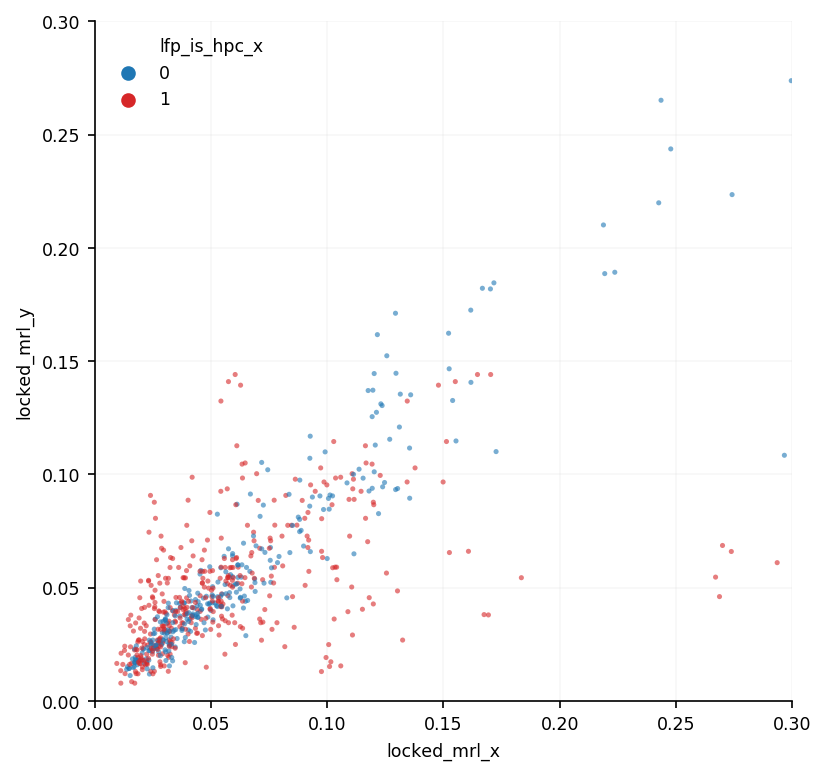

In [545]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(x='locked_mrl_x', y='locked_mrl_y', hue='lfp_is_hpc_x', data=df.query("((sig_x==True) | (sig_y==True))"), 
                alpha=0.6, s=6, linewidth=0, ax=ax)
ax.set_xlim([0, 0.3])
ax.set_ylim([0, 0.3])

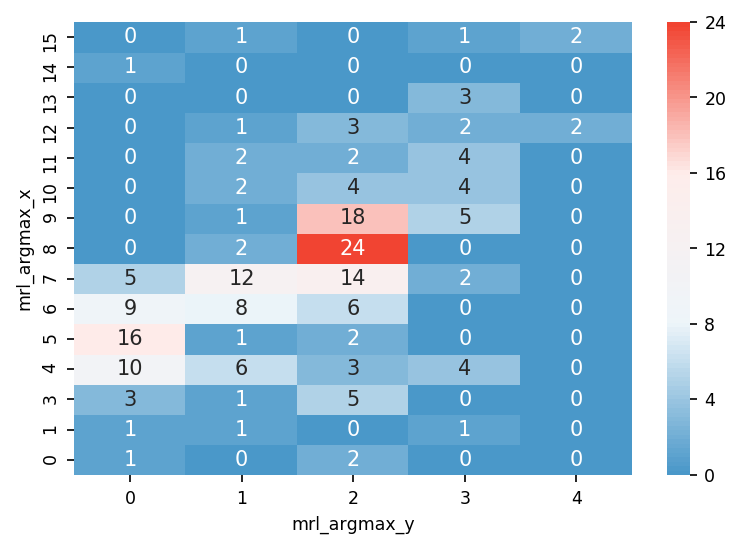

In [526]:
ax = sns.heatmap(df.query("(sig_x==True) & (sig_y==True) & (lfp_is_hpc_x==True)").groupby(['mrl_argmax_x', 'mrl_argmax_y']).size().unstack().fillna(0), 
                 annot=True, cmap=cmap)
ax.invert_yaxis()

(-500, 500)

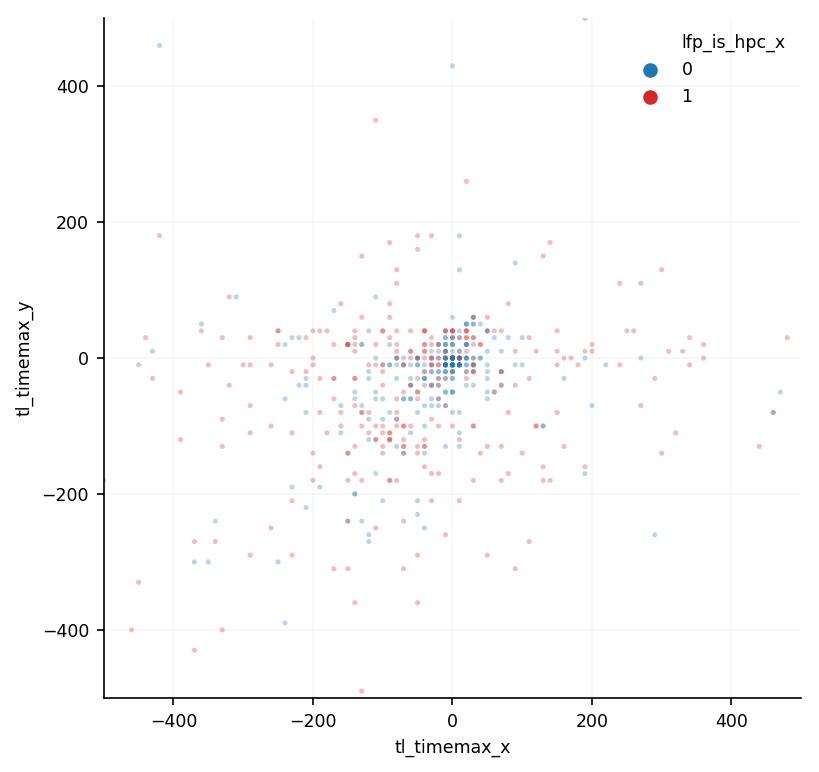

In [547]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(x='tl_timemax_x', y='tl_timemax_y', hue='lfp_is_hpc_x', data=df.query("((sig_x==True) | (sig_y==True))"), 
                alpha=0.3, s=6, linewidth=0, ax=ax)
ax.set_xlim([-500, 500])
ax.set_ylim([-500, 500])

## Analyze wavelet results

In [422]:
upl_df.groupby(['same_hem', 'type']).agg({'subj_sess_unit': len, 'sig': [np.sum, np.mean]})

subj_sess_unit    sig          
                              len    sum      mean
same_hem type                                     
0        ctx-ctx             1089  151.0  0.138659
         ctx-hpc              433   97.0  0.224018
         hpc-ctx              290   49.0  0.168966
         hpc-hpc              116   36.0  0.310345
1        ctx-ctx             1144  247.0  0.215909
         ctx-hpc              515  181.0  0.351456
         ctx-local            459  262.0  0.570806
         hpc-ctx              351   99.0  0.282051
         hpc-hpc               29   19.0  0.655172
         hpc-local            115   88.0  0.765217

In [549]:
upl_df.query("type==['ctx-hpc', 'hpc-hpc']").groupby(['type', 'same_hem', 'lfp_roi']).agg({'subj_sess_unit': len, 'sig': [np.sum, np.mean]})

subj_sess_unit    sig          
                                    len    sum      mean
type    same_hem lfp_roi                                
ctx-hpc 0        AH                 232   57.0  0.245690
                 MH                 189   35.0  0.185185
                 PH                  12    5.0  0.416667
        1        AH                 287  107.0  0.372822
                 MH                 161   42.0  0.260870
                 PH                  67   32.0  0.477612
hpc-hpc 0        AH                  74   29.0  0.391892
                 MH                  40    5.0  0.125000
                 PH                   2    2.0  1.000000
        1        AH                  17   11.0  0.647059
                 PH                  12    8.0  0.666667

In [168]:
# Get a list of units that are phase-locked to
# *both* local and hippocampal LFPs
s = upl_df.groupby(['subj_sess_unit']).sig.sum()
unq = np.unique(s, return_counts=True)
print(unq, np.sum(unq[1]), unq[1]/np.sum(unq[1]))
pl2_units = list(s[s==2].index)

(array([0., 1., 2.]), array([156, 283, 124])) 563 [0.27708703 0.5026643  0.22024867]


In [130]:
# What percent of neurons are phase-locked to the local LFP only,
# HPC LFP only, or both local and HPC LFPs?
df = (upl_df
      .query("(unit_roi2!='hpc')")
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .agg({'sig': lambda x: x * 1,
            'locked_mrl': lambda x: x * 1})
      .unstack())
df.columns = df.columns.map(lambda x: ''.join([*map(str, x)]))
df = df.reset_index().rename(columns={'sig0': 'local_sig', 
                                      'sig1': 'hpc_sig', 
                                      'locked_mrl0': 'local_mrl', 
                                      'locked_mrl1': 'hpc_mrl'})
df['sig_type'] = ''
df.loc[(df.local_sig==1) & (df.hpc_sig==1), 'sig_type'] = 'both'
df.loc[(df.local_sig==0) & (df.hpc_sig==0), 'sig_type'] = 'neither'
df.loc[(df.local_sig==1) & (df.hpc_sig==0), 'sig_type'] = 'local'
df.loc[(df.local_sig==0) & (df.hpc_sig==1), 'sig_type'] = 'hpc'

units = OrderedDict()
for sig_type in ['neither', 'local', 'hpc', 'both']:
    units[sig_type] = df.loc[df.sig_type==sig_type].subj_sess_unit.tolist()
units['all'] = df.subj_sess_unit.tolist()

counts = df.groupby('sig_type').size().reset_index().rename(columns={0: 'n'})
counts['pct'] = counts.n / counts.n.sum()
counts = counts.loc[counts.sig_type!='neither']
counts['sig_type'] = counts.sig_type.astype('category').cat.reorder_categories(['local', 'hpc', 'both'], ordered=True)

df = df.query("sig_type!='neither'")
df['sig_type'] = df.sig_type.astype('category').cat.reorder_categories(['local', 'hpc', 'both'], ordered=True)

In [392]:
df = (upl_df.query("(type==['ctx-local', 'ctx-hpc', 'ctx-ctx'])")
      .groupby(['type', 'same_hem']).agg({'subj_sess_unit': len, 'sig': np.mean}).reset_index())
d = {'ctx-local': 'Local LFP', 'ctx-hpc': 'HPC LFP', 'ctx-ctx': 'Distal LFP',
     'hpc-local': 'HPC Local', 'hpc-hpc': 'HPC-HPC', 'hpc-ctx': 'HPC-CTX'}
df['cat'] = df.type.apply(lambda x: d[x])
df

,type,same_hem,subj_sess_unit,sig,cat
0,ctx-ctx,0,1089,0.138659,Distal LFP
1,ctx-ctx,1,1144,0.215909,Distal LFP
2,ctx-hpc,0,433,0.224018,HPC LFP
3,ctx-hpc,1,515,0.351456,HPC LFP
4,ctx-local,1,459,0.570806,Local LFP


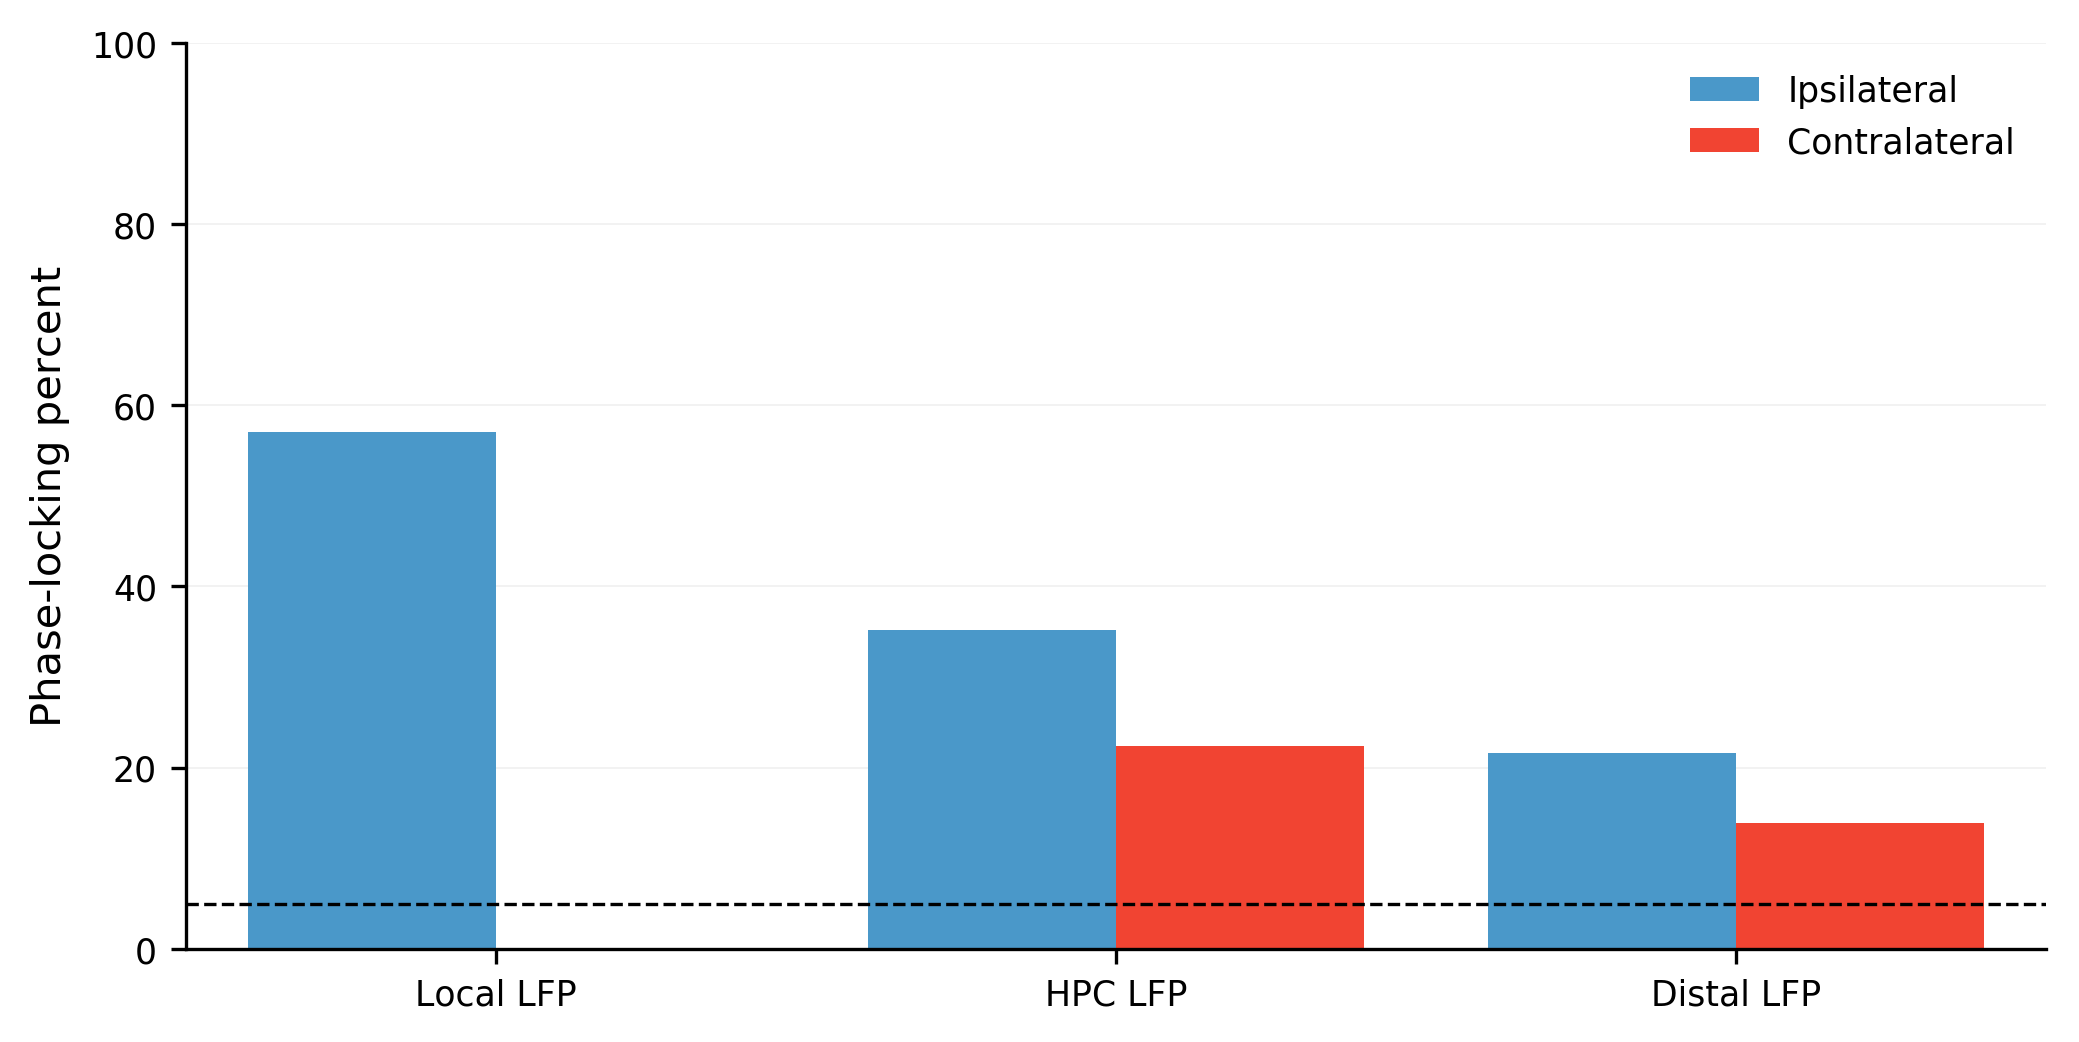

In [397]:
# What percent of extra-hippocampal units are phase-locked to local and HPC LFPs?
df = (upl_df.query("(type==['ctx-local', 'ctx-hpc', 'ctx-ctx'])")
      .groupby(['type', 'same_hem']).agg({'subj_sess_unit': len, 'sig': np.mean}).reset_index())
d = {'ctx-local': 'Local LFP', 'ctx-hpc': 'HPC LFP', 'ctx-ctx': 'Distal LFP'}
df['cat'] = df.type.apply(lambda x: d[x])

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='cat', y='sig', hue='same_hem', order=['Local LFP', 'HPC LFP', 'Distal LFP'], hue_order=[1, 0], 
            data=df, palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[0].set_xlabel('')
ax[0].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
legend = plt.legend()
legend.get_texts()[0].set_text('Ipsilateral')
legend.get_texts()[1].set_text('Contralateral')

Text(0,0.5,'Phase-locking percent')

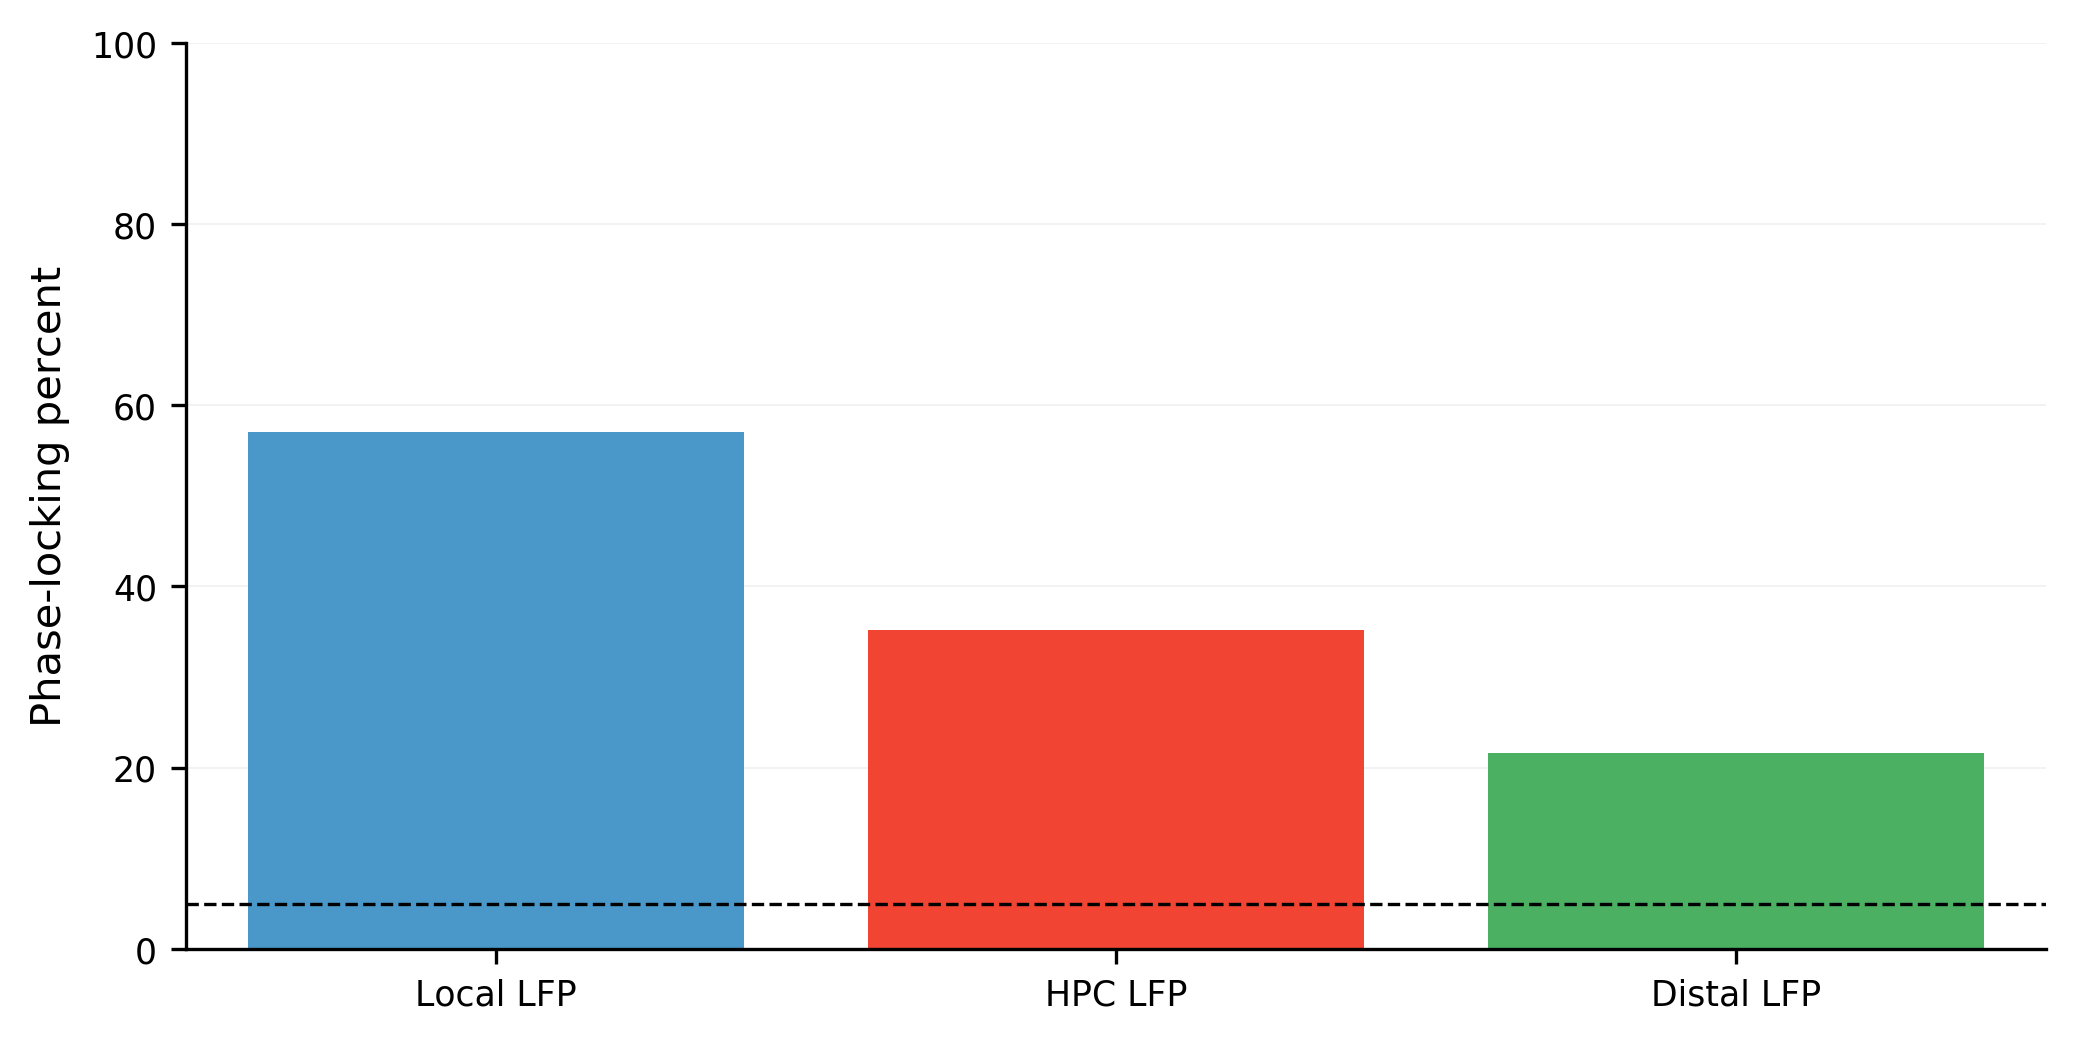

In [372]:
# What percent of extra-hippocampal units are phase-locked to local and HPC LFPs?
df = (upl_df.query("(same_hem==True) & (type==['ctx-local', 'ctx-hpc', 'ctx-ctx'])")
      .groupby('type').agg({'subj_sess_unit': len, 'sig': np.mean}).reset_index())[:3]
df['cat'] = ['Local LFP', 'HPC LFP', 'Distal LFP']

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='cat', y='sig', data=df, palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
#ax[0].set_xticklabels(['Local LFP', 'HPC LFP'])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[0].set_xlabel('')
ax[0].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)

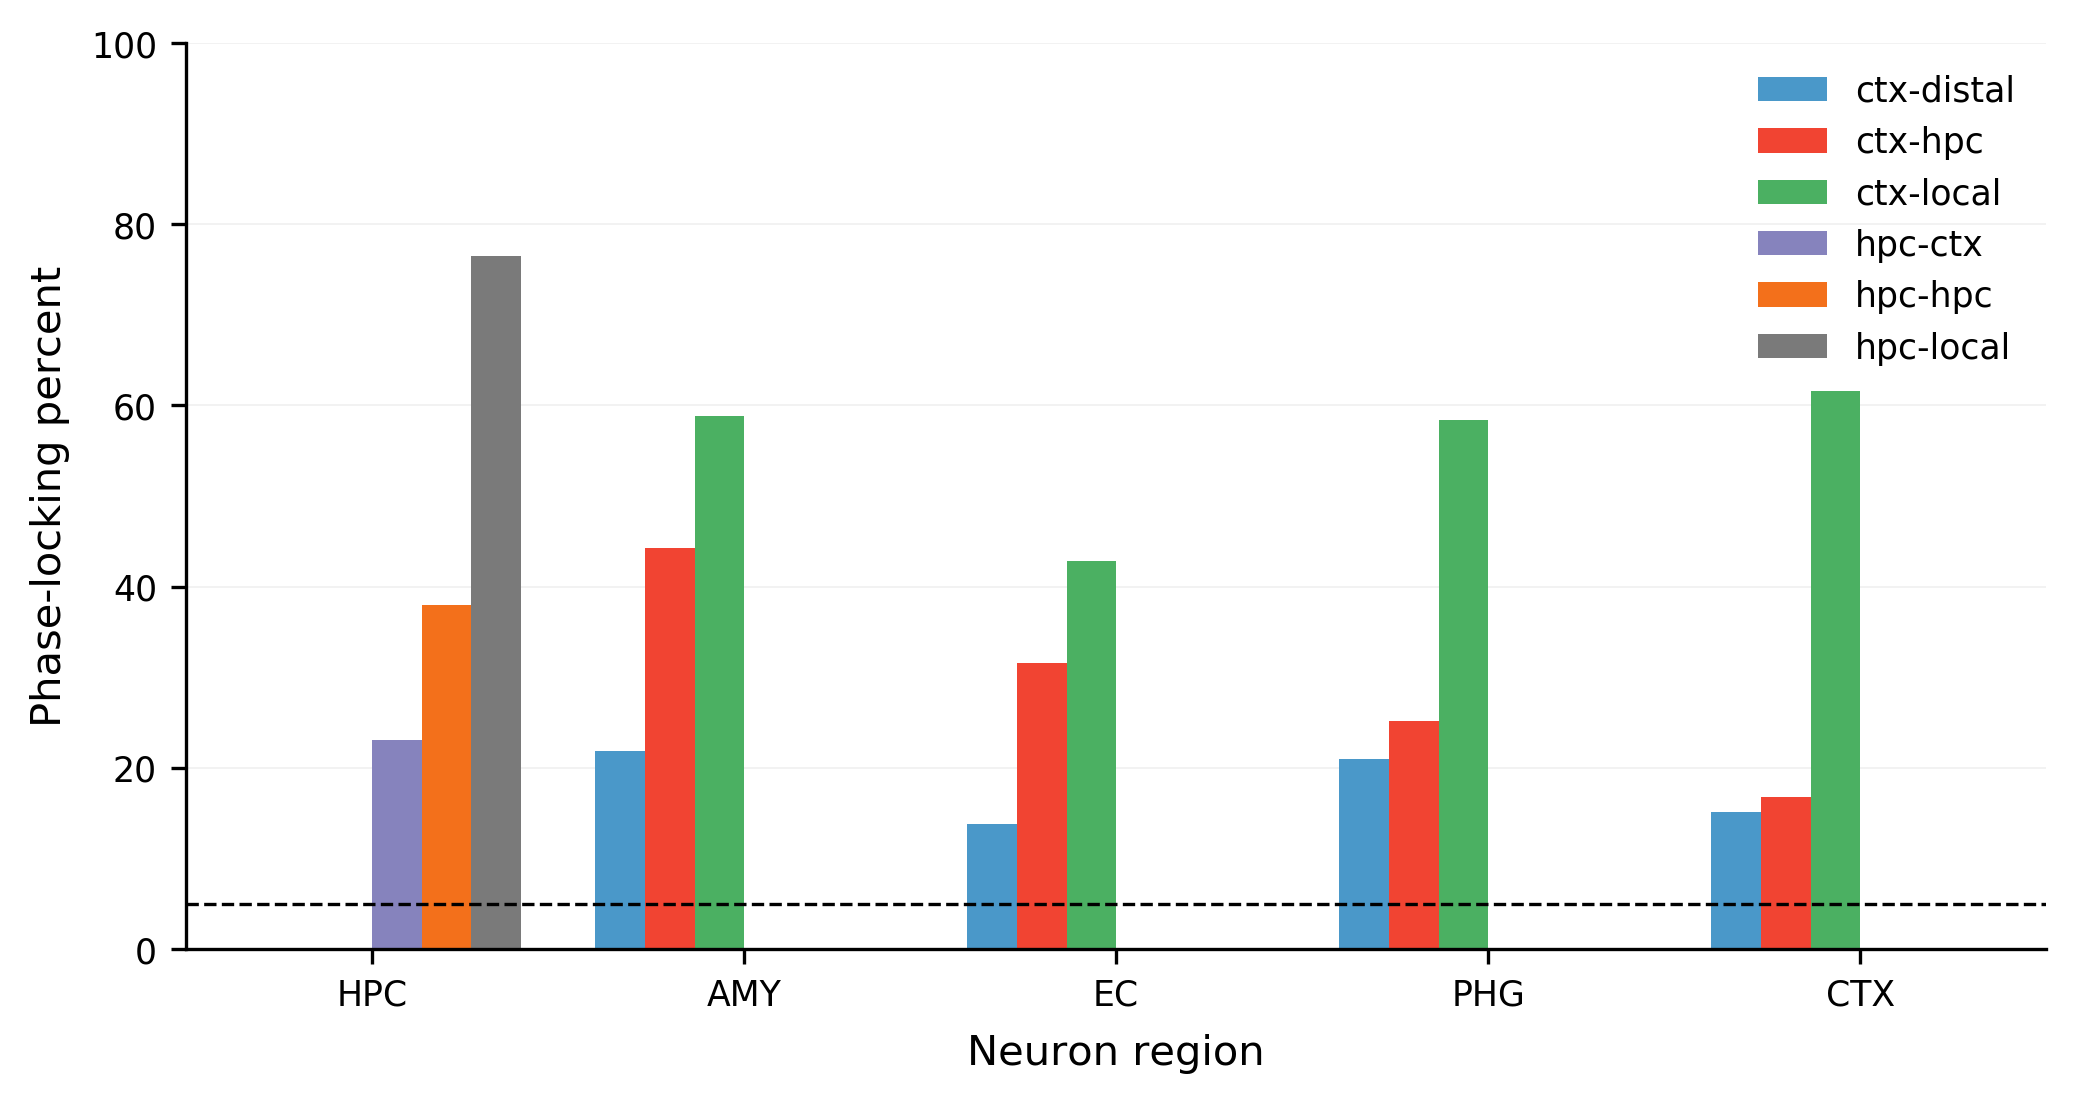

In [312]:
# What percent of units, by region, are phase-locked to local and HPC LFPs?
df = upl_df.groupby(['type', 'unit_roi2']).agg({'subj_sess_unit': len, 'sig': np.mean})

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='unit_roi2', y='sig', data=df.reset_index(), hue='type', palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_xticklabels([roi.upper() for roi in rois])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[0].set_xlabel('Neuron region', fontsize=10, labelpad=5)
ax[0].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
legend = plt.legend()
#legend.get_texts()[0].set_text('Local LFP')
#legend.get_texts()[1].set_text('HPC LFP')

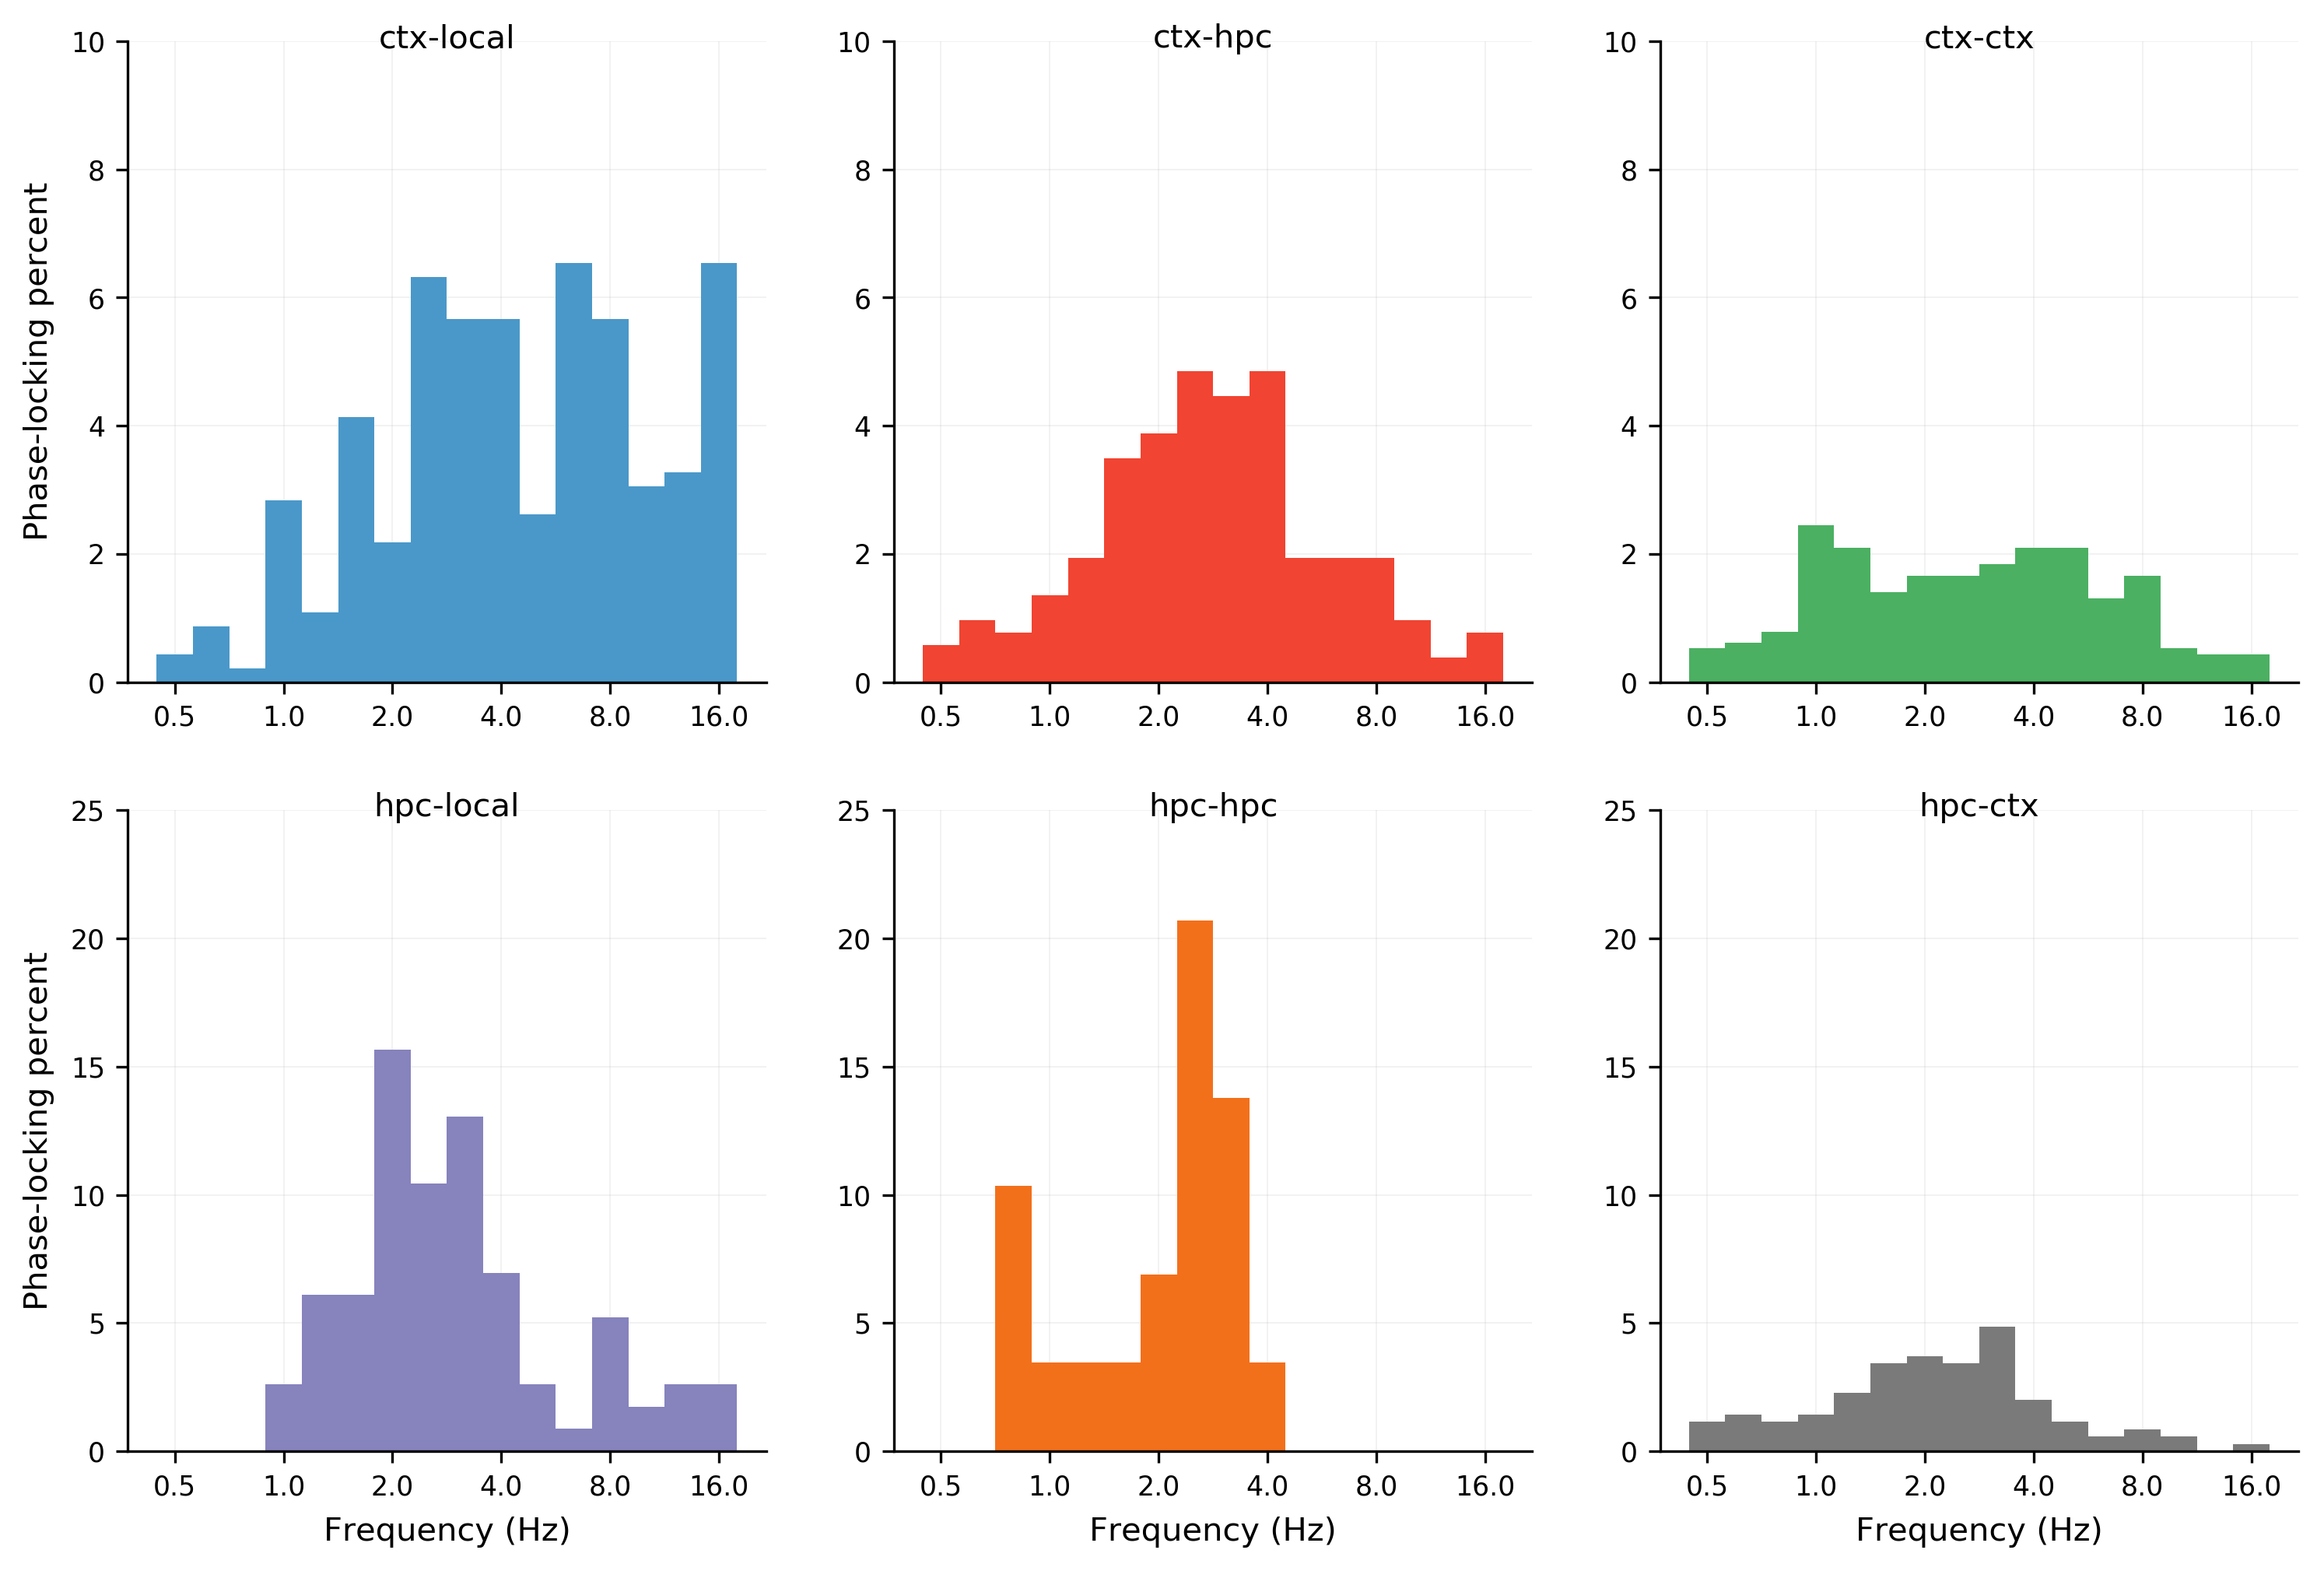

In [413]:
# Ipsilateral
# Phase-locking percent is the percent of total connections in each category.
edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx']
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = upl_df.query("(same_hem==True) & (sig==True) & (type=='{}')".format(edge_type)).groupby(['mrl_argmax']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) / len(upl_df.query("(same_hem==True) & (type=='{}')".format(edge_type)))
df = pd.DataFrame(d).reset_index()

fig, ax = plt.subplots(2, 3, figsize=(12, 8), dpi=300)
ax = np.ravel(ax)

for i in range(len(ax)):
    #sns.barplot(x='index', y=edge_types[i], data=df, color=colors[i], saturation=100, ax=ax[i])
    ax[i].bar(x=df['index'], height=df[edge_types[i]], width=1, color=colors[i])
    ax[i].set_xticks(np.arange(len(freqs))[::3])
    ax[i].set_xticklabels(np.round(freqs[::3], 1))
    if i in [3, 4, 5]:
        ax[i].set_xlabel('Frequency (Hz)', fontsize=10, labelpad=5)   
    else:
        ax[i].set_xlabel('')
    if i in [0, 1, 2]:
        ax[i].set_ylim([0, 0.1])
        ax[i].set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1])
        ax[i].set_yticklabels([0, 2, 4, 6, 8, 10])
    else:
        ax[i].set_ylim([0, 0.25])
        ax[i].set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
        ax[i].set_yticklabels([0, 5, 10, 15, 20, 25])
    if i in [0, 3]:
        ax[i].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
    else:
        ax[i].set_ylabel('')
    ax[i].set_title(edge_types[i], fontsize=10, y=0.96)

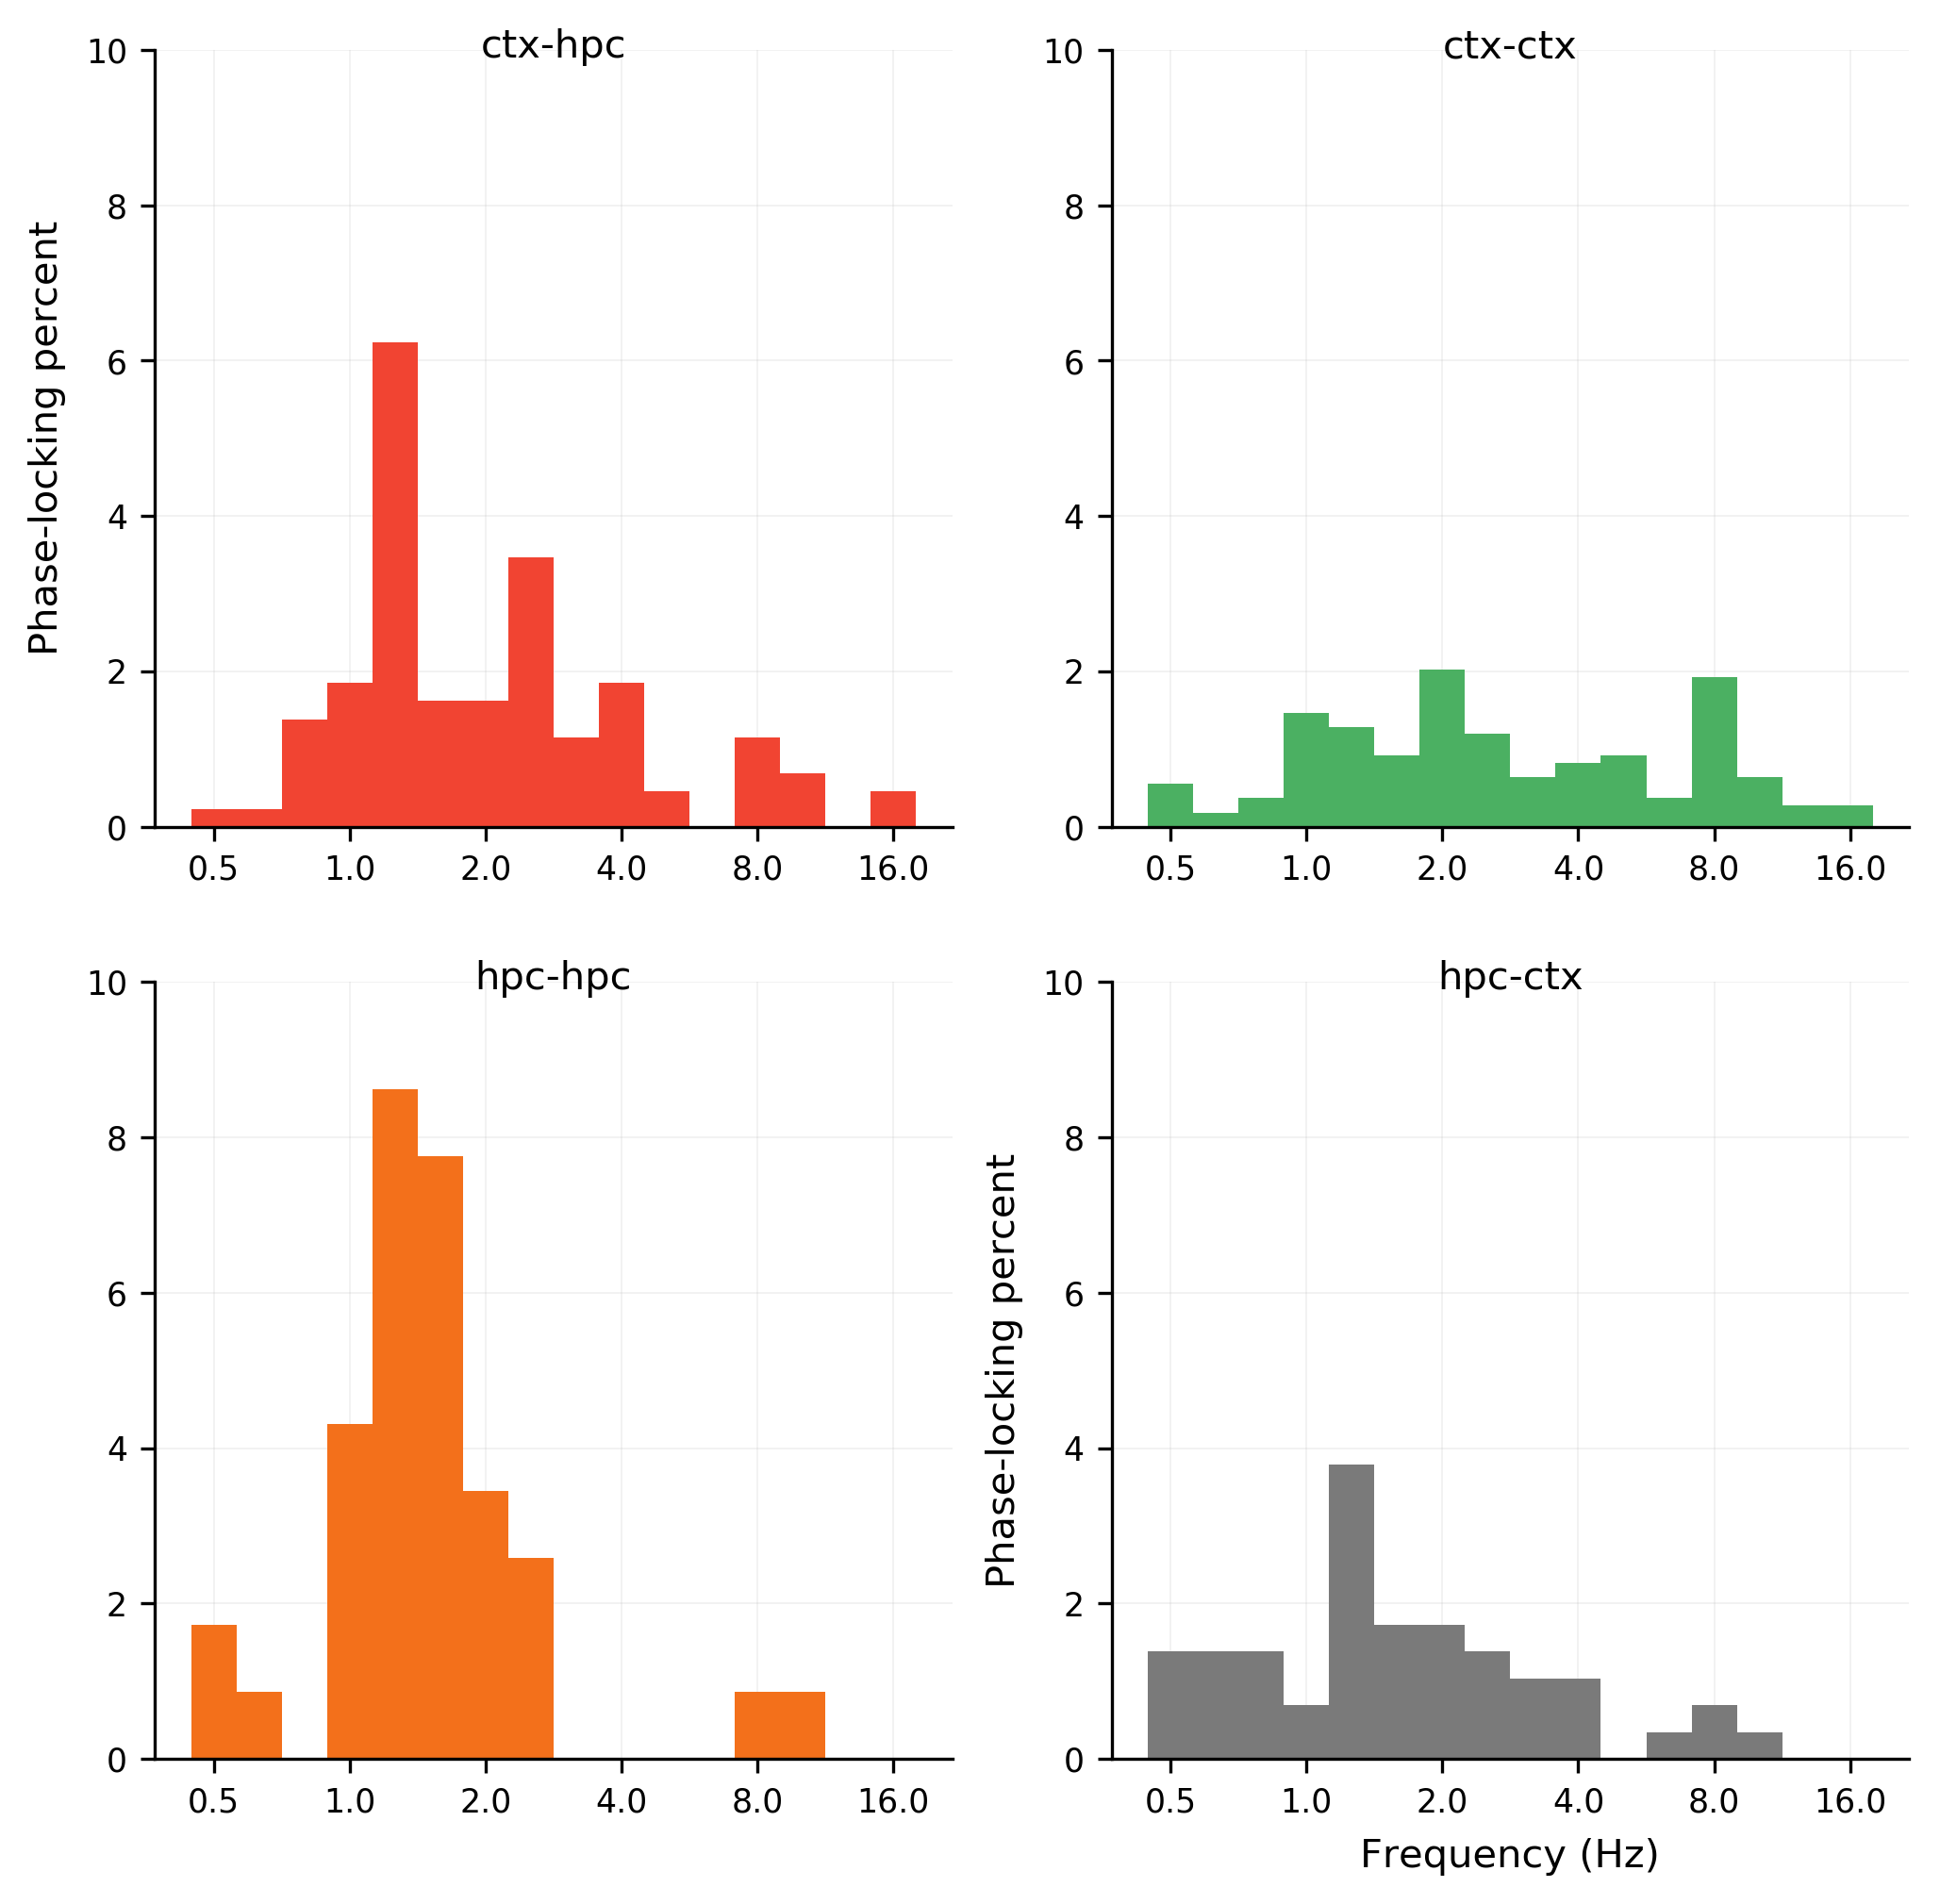

In [421]:
# Contralateral
edge_types = ['ctx-hpc', 'ctx-ctx', 'hpc-hpc', 'hpc-ctx']
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = upl_df.query("(same_hem==False) & (sig==True) & (type=='{}')".format(edge_type)).groupby(['mrl_argmax']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) / len(upl_df.query("(same_hem==False) & (type=='{}')".format(edge_type)))
df = pd.DataFrame(d).reset_index()

fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
ax = np.ravel(ax)

for i in range(len(ax)):
    #sns.barplot(x='index', y=edge_types[i], data=df, color=colors[i], saturation=100, ax=ax[i])
    ax[i].bar(x=df['index'], height=df[edge_types[i]], width=1, color=colors[[1, 2, 4, 5][i]])
    ax[i].set_xticks(np.arange(len(freqs))[::3])
    ax[i].set_xticklabels(np.round(freqs[::3], 1))
    if i in [3, 4, 5]:
        ax[i].set_xlabel('Frequency (Hz)', fontsize=10, labelpad=5)   
    else:
        ax[i].set_xlabel('')
    ax[i].set_ylim([0, 0.1])
    ax[i].set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1])
    ax[i].set_yticklabels([0, 2, 4, 6, 8, 10])
    if i in [0, 3]:
        ax[i].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
    else:
        ax[i].set_ylabel('')
    ax[i].set_title(edge_types[i], fontsize=10, y=0.96)

In [612]:
# What percent of neurons are phase-locked to the local LFP only,
# HPC LFP only, or both local and HPC LFPs?
df = (upl_df
      .query("(type==['ctx-local', 'ctx-hpc'])")
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .agg({'sig': lambda x: x * 1,
            'locked_mrl': lambda x: x * 1})
      .unstack())
df.columns = df.columns.map(lambda x: ''.join([*map(str, x)]))
df = df.reset_index().rename(columns={'sig0': 'local_sig', 
                                      'sig1': 'hpc_sig', 
                                      'locked_mrl0': 'local_mrl', 
                                      'locked_mrl1': 'hpc_mrl'})
df['hpc_sig'] = df.hpc_sig.apply(lambda x: np.any(x))
df['hpc_mrl'] = df.hpc_mrl.apply(lambda x: np.mean(x))
df['sig_type'] = ''
df.loc[(df.local_sig==1) & (df.hpc_sig==1), 'sig_type'] = 'both'
df.loc[(df.local_sig==0) & (df.hpc_sig==0), 'sig_type'] = 'neither'
df.loc[(df.local_sig==1) & (df.hpc_sig==0), 'sig_type'] = 'local'
df.loc[(df.local_sig==0) & (df.hpc_sig==1), 'sig_type'] = 'hpc'

units = OrderedDict()
for sig_type in ['neither', 'local', 'hpc', 'both']:
    units[sig_type] = df.loc[df.sig_type==sig_type].subj_sess_unit.tolist()
units['all'] = df.subj_sess_unit.tolist()

counts = df.groupby('sig_type').size().reset_index().rename(columns={0: 'n'})
counts['pct'] = counts.n / counts.n.sum()
counts = counts.loc[counts.sig_type!='neither']
counts['sig_type'] = counts.sig_type.astype('category').cat.reorder_categories(['local', 'hpc', 'both'], ordered=True)

df = df.query("sig_type!='neither'")
df['sig_type'] = df.sig_type.astype('category').cat.reorder_categories(['local', 'hpc', 'both'], ordered=True)

In [614]:
counts

,sig_type,n,pct
0,both,137,0.298475
1,hpc,59,0.128540
2,local,125,0.272331


SpearmanrResult(correlation=0.16252463922895155, pvalue=0.0037131766511993305)

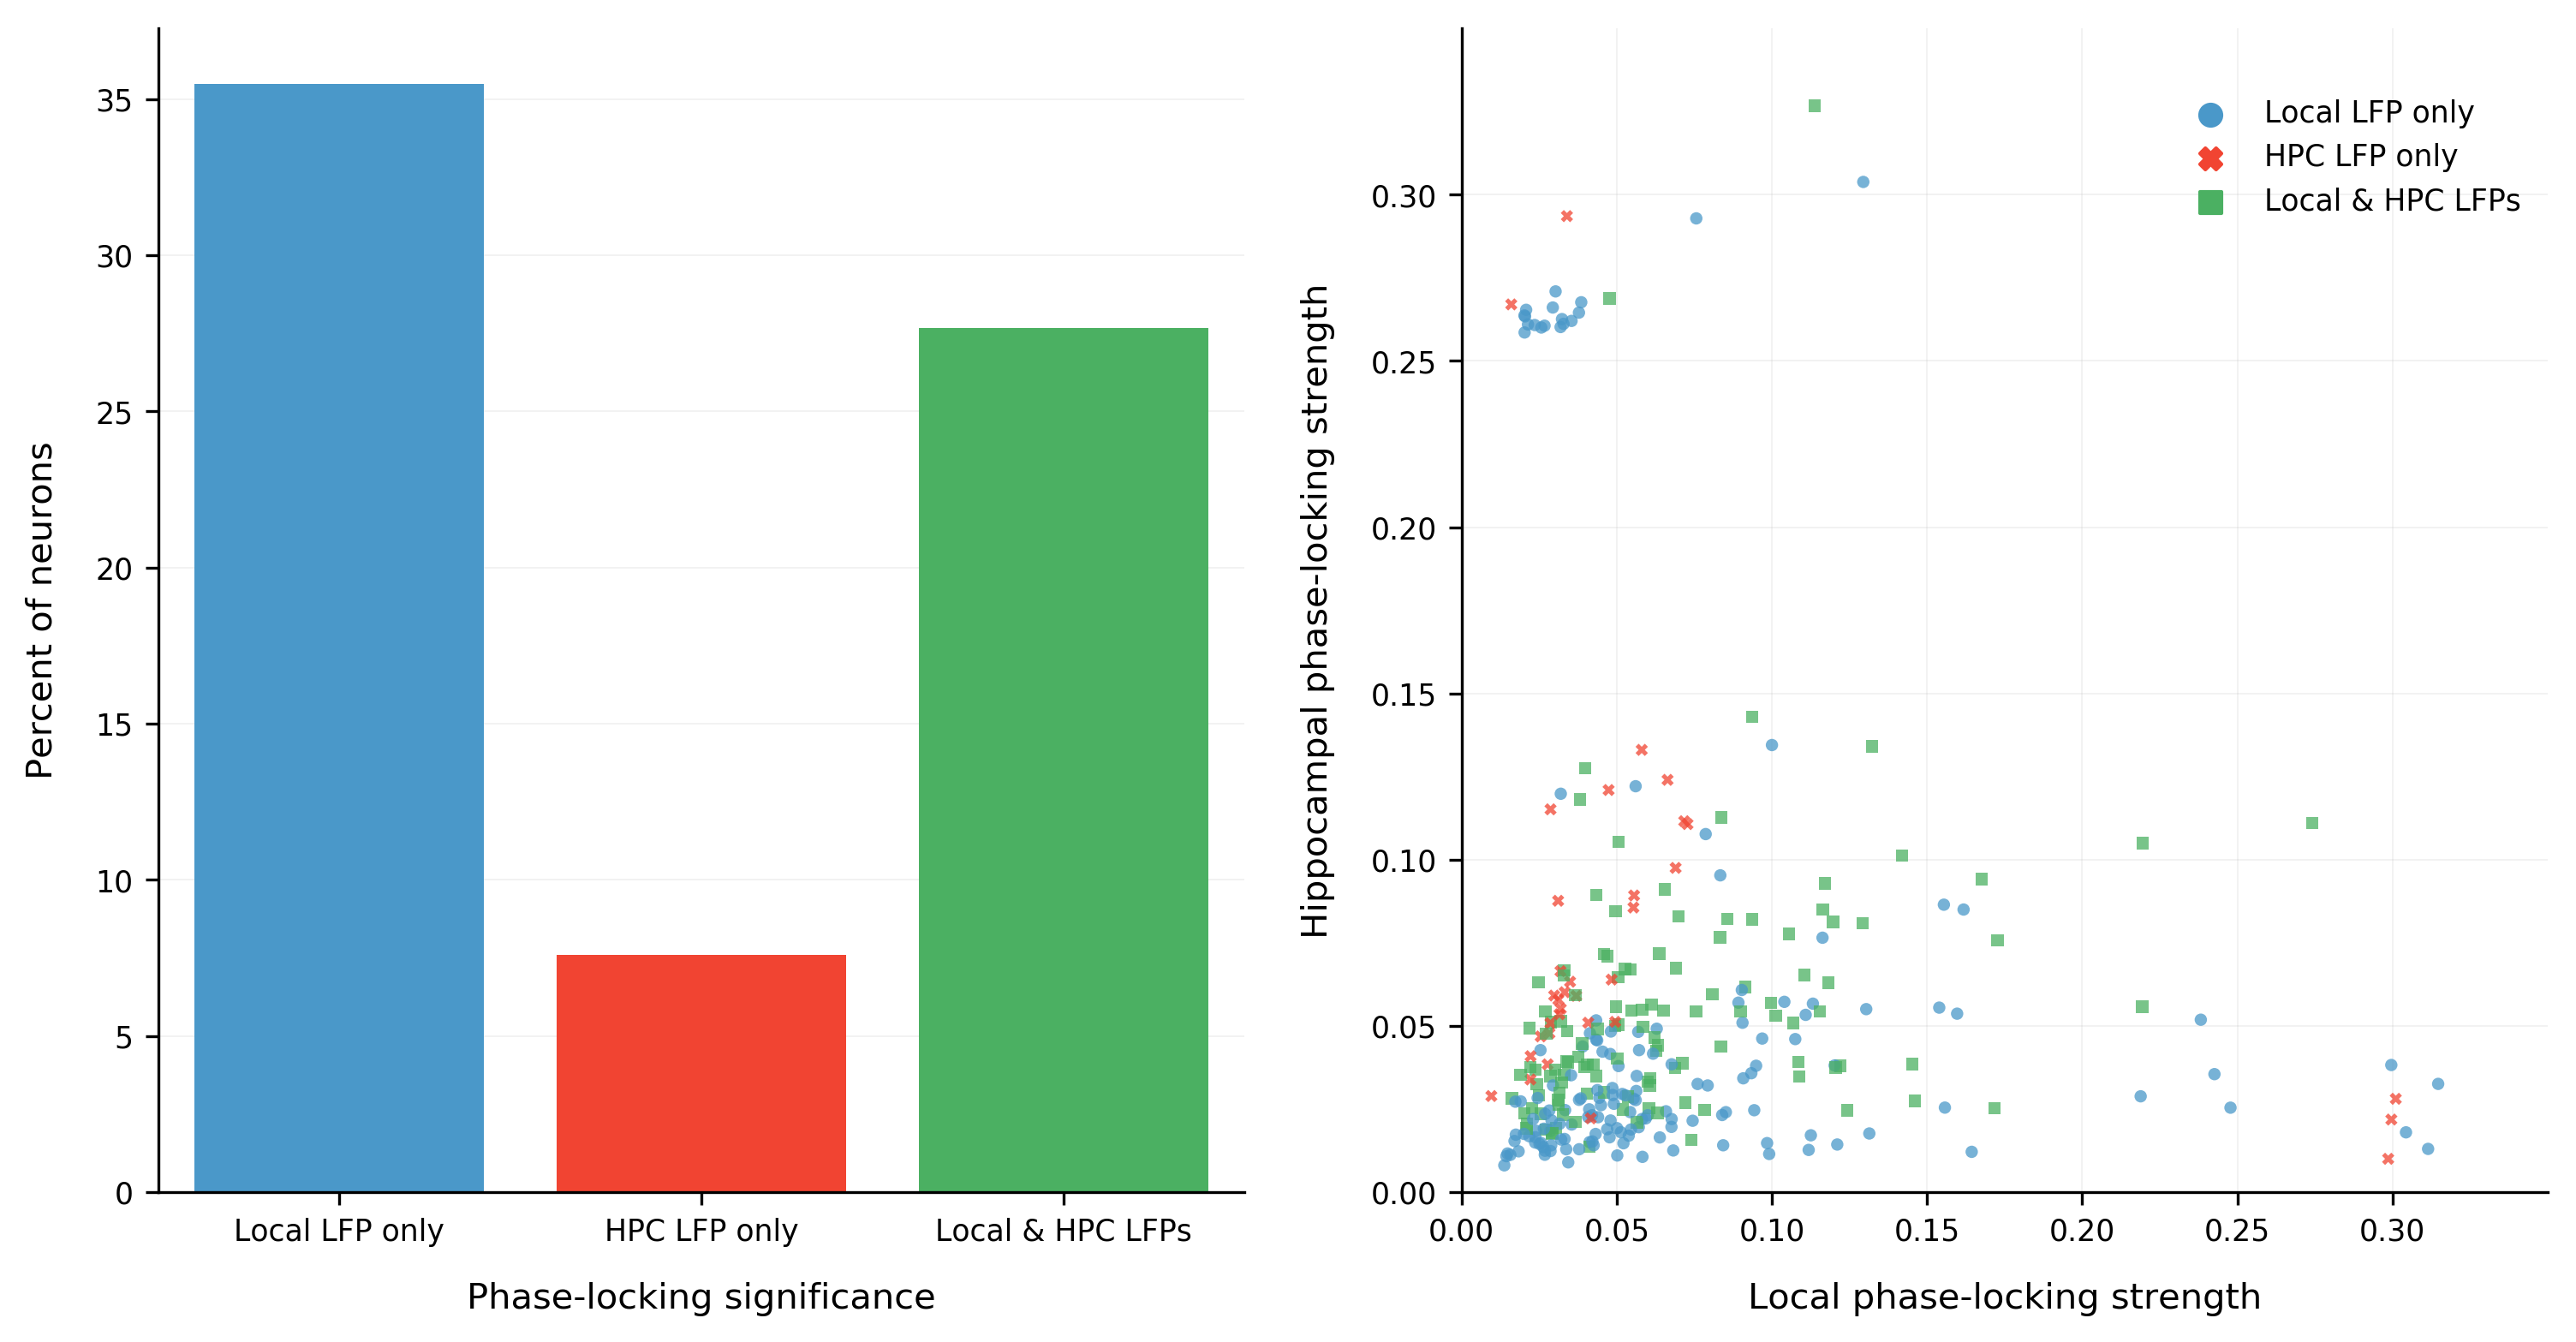

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='sig_type', y='pct', data=counts.loc[counts.sig_type!='neither'], 
            palette=colors, saturation=100, ax=ax[0])
ax[0].set_xticklabels(['Local LFP only', 'HPC LFP only', 'Local & HPC LFPs'])
ax[0].set_xlabel('Phase-locking significance', fontsize=10, labelpad=10)
ax[0].set_yticks(np.arange(0, 0.36, 0.05))
ax[0].set_yticklabels(np.arange(0, 36, 5))
ax[0].set_ylabel('Percent of neurons', fontsize=10, labelpad=10)

sns.scatterplot(x=df.query("sig_type!='neither'").local_mrl, 
                y=df.query("sig_type!='neither'").hpc_mrl, 
                hue=df.query("sig_type!='neither'").sig_type, 
                style=df.query("sig_type!='neither'").sig_type,
                linewidth=0, alpha=0.75, s=12, palette=colors[:3], ax=ax[1])
ax[1].set_xlim([0, 0.35])
ax[1].set_xticks(np.arange(0, .35, .05))
ax[1].set_ylim([0, 0.35])
ax[1].set_yticks(np.arange(0, .35, .05))

ax[1].set_xlabel('Local phase-locking strength', fontsize=10, labelpad=10)
ax[1].set_ylabel('Hippocampal phase-locking strength', fontsize=10, labelpad=10)

legend = plt.legend()
legend.get_texts()[0].set_text('')
legend.get_texts()[1].set_text('Local LFP only')
legend.get_texts()[2].set_text('HPC LFP only')
legend.get_texts()[3].set_text('Local & HPC LFPs')

stats.spearmanr(df.local_mrl, df.hpc_mrl)

In [169]:
# Among units phase-locked to both local and HPC LFPs,
# is the hippocampal band lower, the same, or higher
# than the local band, and is there a group-level difference
# in local vs HPC phase-lock frequency (Wilcoxon signed-rank)?
df = (upl_df
      .query("(subj_sess_unit=={})".format(pl2_units))
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .mrl_argmax.apply(int)
      .unstack()
      .rename(columns={0: 'local', 1: 'hpc'}))
df['vs'] = np.sign(df['hpc'] - df['local'])
ind, dat = np.unique(df.vs, return_counts=True)
counts = pd.DataFrame(index=ind, data=dat).reset_index().rename(columns={'index': 'cat', 0: 'count'})
m = df.groupby(['local', 'hpc']).size().unstack().fillna(0)

print(counts)
stats.wilcoxon(df.hpc, df.local)

   cat  count
0   -1     48
1    0     57
2    1     19


WilcoxonResult(statistic=462.5, pvalue=1.917936335600008e-05)

Signed-rank test for HPC vs. local frequency band: WilcoxonResult(statistic=462.5, pvalue=1.917936335600008e-05)
Binomial test for HPC=Local obs. vs. chance: pvalue=8.854203811470534e-11


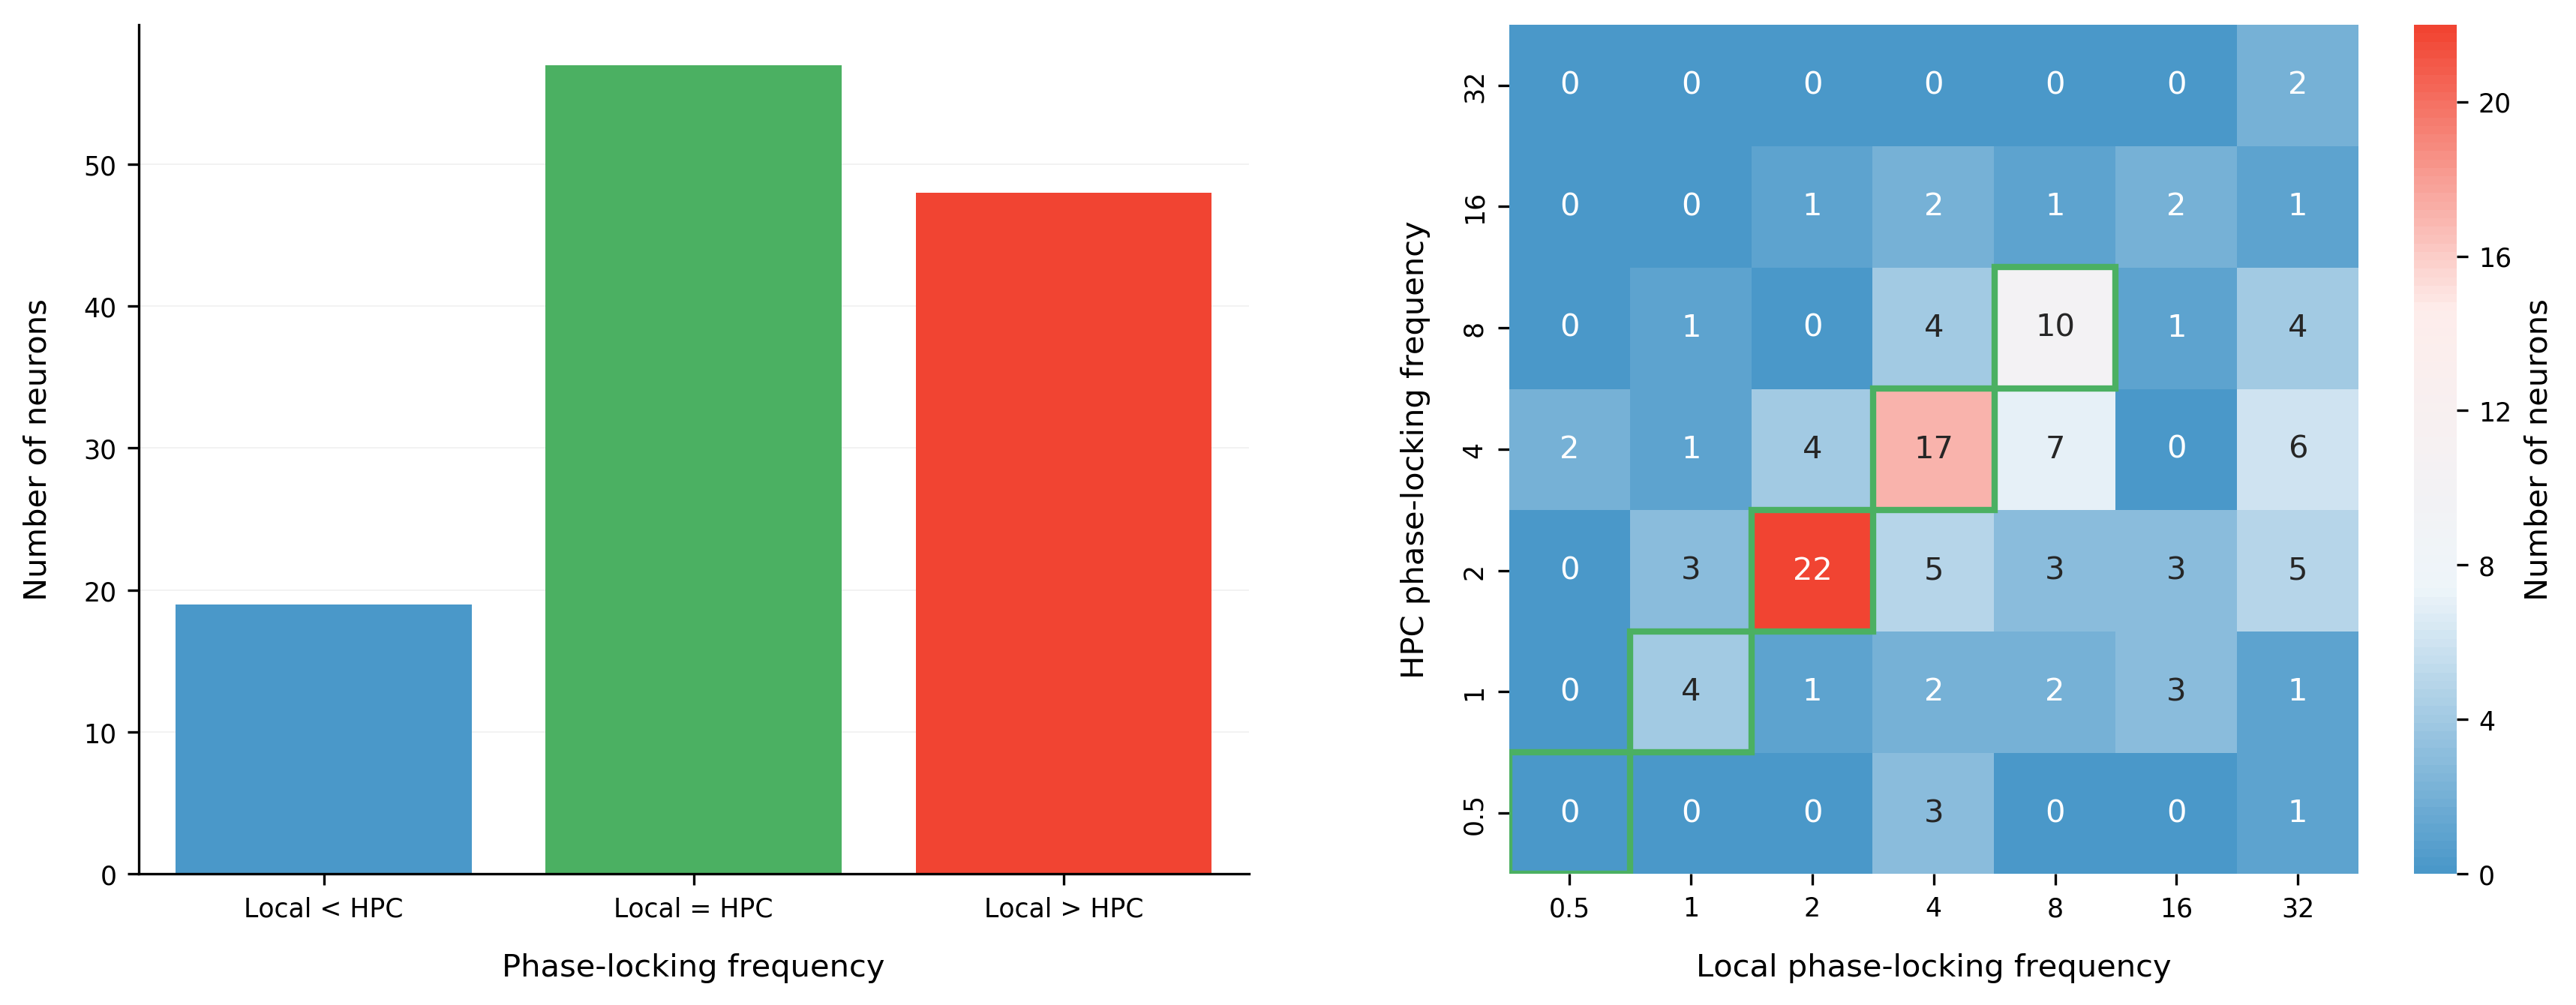

In [174]:
# Among units phase-locked to both local and HPC LFPs,
# is the hippocampal band lower, the same, or higher
# than the local band, and is there a group-level difference
# in local vs HPC phase-lock frequency (Wilcoxon signed-rank)?
df = (upl_df
      .query("(subj_sess_unit=={})".format(pl2_units))
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .mrl_argmax.apply(int)
      .unstack()
      .rename(columns={0: 'local', 1: 'hpc'}))
df['vs'] = np.sign(df['hpc'] - df['local'])
ind, dat = np.unique(df.vs, return_counts=True)
counts = pd.DataFrame(index=ind, data=dat).reset_index().rename(columns={'index': 'cat', 0: 'count'})
m = df.groupby(['local', 'hpc']).size().unstack().fillna(0)
print('Signed-rank test for HPC vs. local frequency band:', stats.wilcoxon(df.hpc, df.local))

# Do hippocampal and local phase-locking frequencies coincide above chance?
exp_rate = np.sum(((df.groupby(['local']).size()) / len(df)) * 
                   (df.groupby(['hpc']).size() / len(df)))
print('Binomial test for HPC=Local obs. vs. chance: pvalue=', 
      stats.binom_test(np.sum(df.hpc==df.local), n=len(df), p=exp_rate), sep='')

# Plot.
fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='cat', y='count', data=counts, order=[1, 0, -1], 
            palette=(colors[0], colors[2], colors[1]), saturation=100, ax=ax[0])
ax[0].set_xticklabels(['Local < HPC', 'Local = HPC', 'Local > HPC'])
ax[0].set_xlabel('Phase-locking frequency', fontsize=10, labelpad=10)
ax[0].set_ylabel('Number of neurons', fontsize=10, labelpad=10)

sns.heatmap(m.T, annot=True, ax=ax[1], cmap=cmap, square=True)

# ax[1].plot([0, 3.97], np.ones(2) * 4.98, '-', color=colors[0], linewidth=2) # horizontal
# ax[1].plot(np.ones(2) * 0.02, [1.03, 5], '-', color=colors[0], linewidth=2) # vertical
# ax[1].plot([1.03, 5], np.ones(2) * 0.02, '-', color=colors[1], linewidth=2) # horizontal
# ax[1].plot(np.ones(2) * 4.98, [0, 3.97], '-', color=colors[1], linewidth=2) # vertical
for i in range(5):
#     ax[1].plot([i, i+0.97], np.ones(2) * (i+1.03), '-', color=colors[0], linewidth=2) # horizontal
#     ax[1].plot(np.ones(2) * (i+0.97), [i+1.03, i+2.03], '-', color=colors[0], linewidth=2) # vertical
#     ax[1].plot([i+1.03, i+2], np.ones(2) * (i+0.97), '-', color=colors[1], linewidth=2) # horizontal
#     ax[1].plot(np.ones(2) * (i+1.03), [i-0.03, i+0.97], '-', color=colors[1], linewidth=2) # vertical
    ax[1].add_patch(patches.Rectangle((i, i), 1, 1, linewidth=2, edgecolor=colors[2], facecolor='none'))

ax[1].set_xticklabels(bands_fancy2.values(), ha='center')
ax[1].set_yticklabels(bands_fancy2.values(), va='center')
ax[1].set_xlabel('Local phase-locking frequency', fontsize=10, labelpad=10)
ax[1].set_ylabel('HPC phase-locking frequency', fontsize=10, labelpad=10)
ax[1].invert_yaxis()
cbar = ax[1].collections[0].colorbar
cbar.set_label('Number of neurons', fontsize=10)

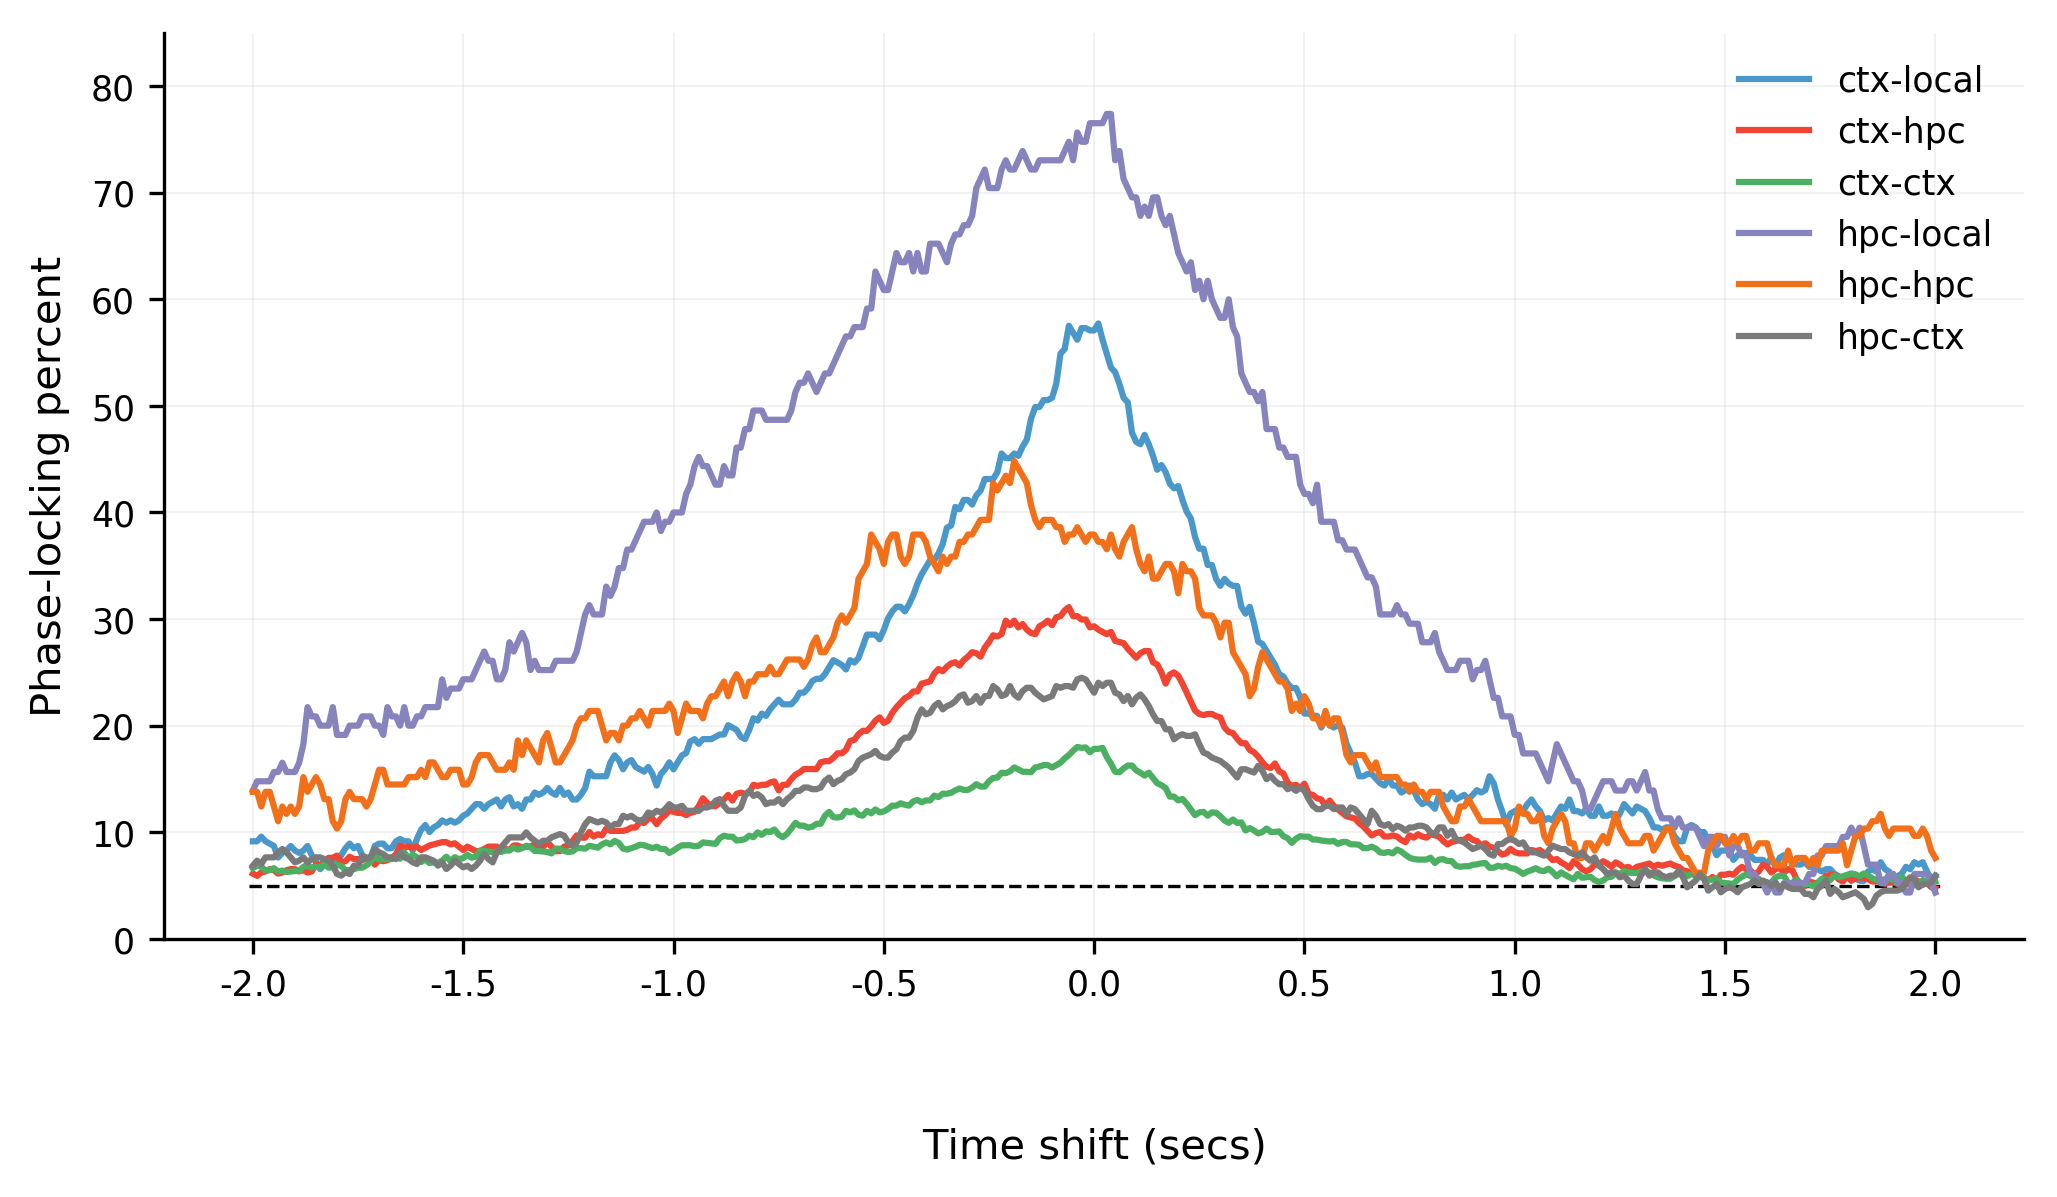

In [432]:
# Plot the percent of phase-locked units at different time lags
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)
edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx']
for i in range(len(edge_types)):
    ax[0].plot(np.mean(np.flip(upl_df.query("(type=='{}')".format(edge_types[i])).tl_sig.tolist(), axis=-1), axis=0), 
               label=edge_types[i], color=colors[i], linewidth=1.5)

ax[0].hlines(y=0.05, xmin=-1, xmax=401, color='k', linestyle='--')
ax[0].set_xticks(np.linspace(0, 400, 9))
ax[0].set_xticklabels(np.linspace(-2, 2, 401)[np.linspace(0, 400, 9, dtype=int)])
ax[0].set_ylim([0, 0.85])
ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
ax[0].set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80])
ax[0].set_xlabel('Time shift (secs)', fontsize=10, labelpad=30)
ax[0].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
ax[0].legend()

In [442]:
(len(upl_df.query("(sig==True) & (-501<tl_timemax<501) & (type==['ctx-local', 'ctx-hpc', 'ctx-ctx'])")) 
 / len(upl_df.query("(sig==True) & (type==['ctx-local', 'ctx-hpc', 'ctx-ctx'])")))

0.9189765458422174

In [439]:
upl_df.query("(sig==True) & (-501<tl_timemax<501) & (type==['ctx-local', 'ctx-hpc', 'ctx-ctx'])").groupby('type').tl_timemax.describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
ctx-ctx,351.0,-48.091168,131.026945,-430.0,-115.0,-30.0,20.0,440.0
ctx-hpc,258.0,-47.519380,143.852124,-500.0,-120.0,-40.0,20.0,430.0
ctx-local,253.0,-32.411067,103.870135,-450.0,-60.0,-10.0,10.0,470.0


In [443]:
print(stats.mannwhitneyu(upl_df.query("(sig==True) & (-501<tl_timemax<501) & (type=='ctx-local')").tl_timemax, 
                         upl_df.query("(sig==True) & (-501<tl_timemax<501) & (type=='ctx-hpc')").tl_timemax))
print(stats.levene(upl_df.query("(sig==True) & (-501<tl_timemax<501) & (type=='ctx-local')").tl_timemax, 
                   upl_df.query("(sig==True) & (-501<tl_timemax<501) & (type=='ctx-hpc')").tl_timemax))
print(stats.spearmanr(upl_df.query("(sig==True) & (-501<tl_timemax<501) & (type=='ctx-hpc')").tl_timemax, 
                      upl_df.query("(sig==True) & (-501<tl_timemax<501) & (type=='ctx-hpc')").mrl_argmax))

MannwhitneyuResult(statistic=27980.5, pvalue=0.002606596103883297)
LeveneResult(statistic=23.296918481949092, pvalue=1.8381263717779994e-06)
SpearmanrResult(correlation=0.1948364494796267, pvalue=0.0016635381444106328)


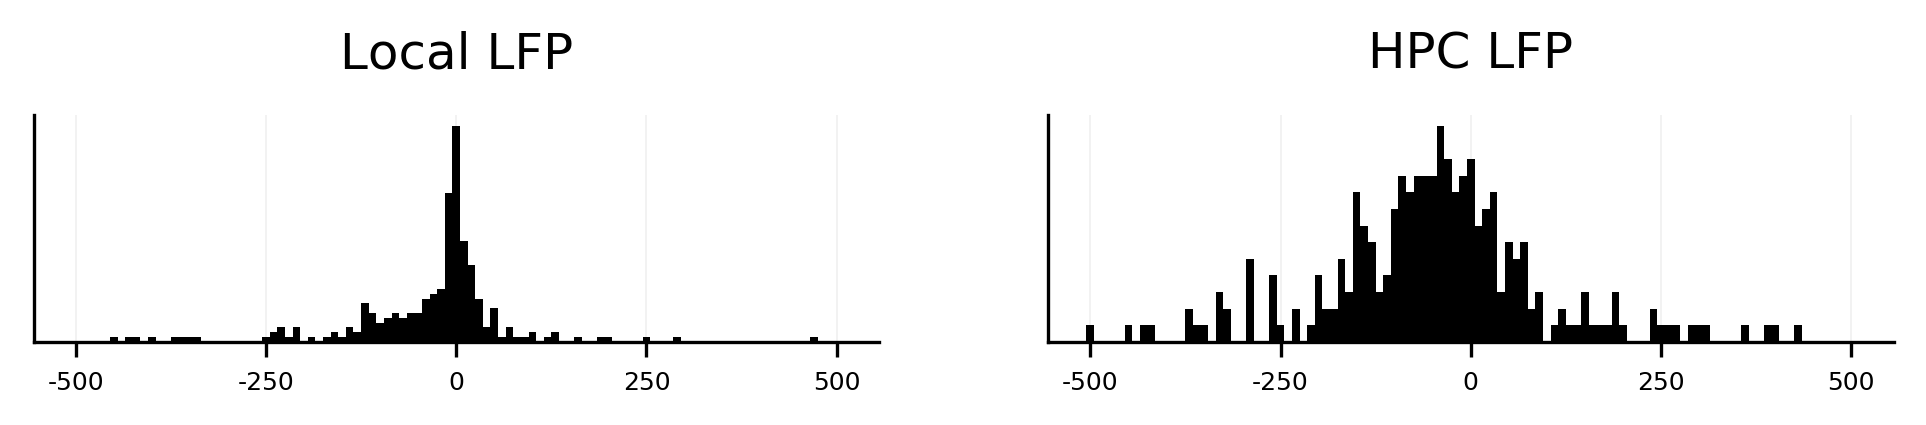

In [444]:
local_d = (upl_df
           .query("(sig==True) & (type=='ctx-local')")
           .groupby('tl_timemax')
           .size()
           .to_dict())
hpc_d = (upl_df
         .query("(sig==True) & (type=='ctx-hpc')")
         .groupby('tl_timemax')
         .size()
         .to_dict())
counts = []
for i in np.arange(-500, 501, 10):
    counts.append([local_d.get(i, 0), hpc_d.get(i, 0)])
counts = pd.DataFrame(counts, columns=['local', 'hpc']).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(8, 1), dpi=300)
ax = np.ravel(ax)

ax[0].bar(counts.index, counts.local, width=1, color='k')
ax[0].set_title('Local LFP', fontsize=12, y=1.1)

ax[1].bar(counts.index, counts.hpc, width=1, color='k')
ax[1].set_yticks(np.arange(0, 15, 3))
ax[1].set_title('HPC LFP', fontsize=12, y=1.1)

for i in range(2):
    ax[i].set_xticks(np.arange(0, 101, 25))
    ax[i].set_xticklabels(np.arange(-500, 501, 250), fontsize=6)
    ax[i].set_yticks([])
    #ax[i].set_xlabel('Time shift (ms)', labelpad=5)
    #ax[i].set_ylabel('Number of neurons', labelpad=5)

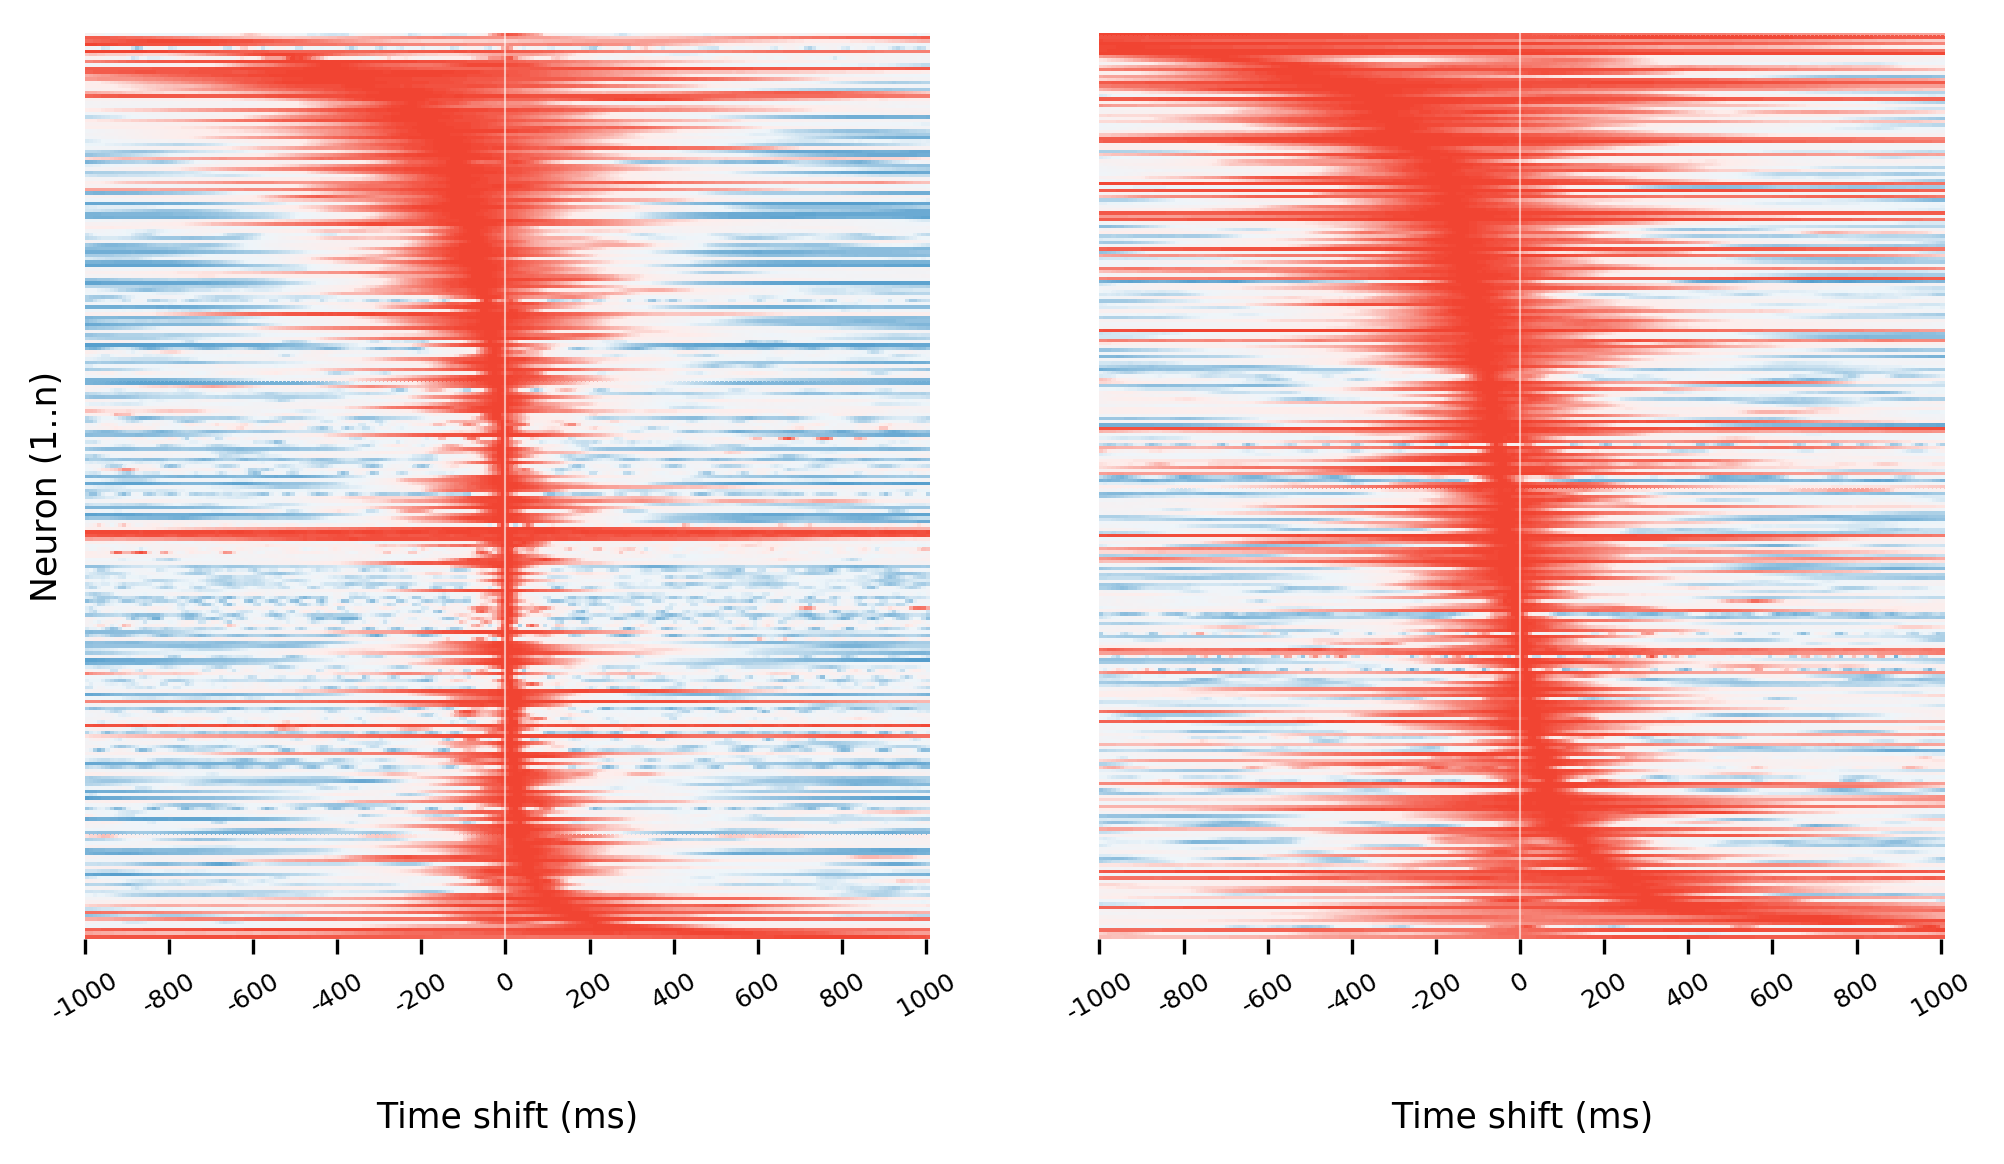

In [447]:
local_tl_mrls = np.array(upl_df.query("(sig==True) & (type=='ctx-local')")
                         .sort_values('tl_timemax').tl_mrls_locked_band.tolist())
hpc_tl_mrls = np.array(upl_df.query("(sig==True) & (type=='ctx-hpc')")
                       .sort_values('tl_timemax').tl_mrls_locked_band.tolist())

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.heatmap((local_tl_mrls[:, 100:301].T / np.max(local_tl_mrls, axis=1)).T, ax=ax[0], 
            vmin=0, vmax=1, cmap=cmap, cbar=False)
sns.heatmap((hpc_tl_mrls[:, 100:301].T / np.max(hpc_tl_mrls, axis=1)).T, ax=ax[1], 
            vmin=0, vmax=1, cmap=cmap, cbar=False)
ax[0].axvline(x=100, color='w', linewidth=0.5, alpha=0.6)
ax[1].axvline(x=100, color='w', linewidth=0.5, alpha=0.6)

for i in range(2):
    ax[i].set_xticks(np.arange(0, 201, 20))
    ax[i].set_xticklabels(np.arange(-1000, 1001, 200), fontsize=6, rotation=30)
    ax[i].set_yticks([])
    ax[i].set_xlabel('Time shift (ms)', labelpad=18)
ax[0].set_ylabel('Neuron (1..n)', labelpad=5)

plt.show()

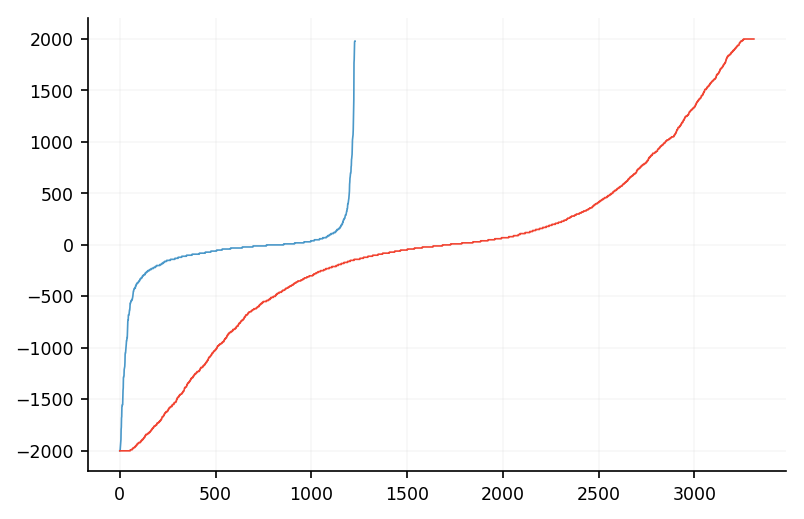

In [448]:
plt.plot(np.sort(upl_df.query("sig==True").tl_timemax), color=colors[0])
plt.plot(np.sort(upl_df.query("sig==False").tl_timemax), color=colors[1])

## Writing Morlet function

In [53]:
np.logspace(np.log10(0.5), np.log10(16), 16)

array([ 0.5       ,  0.62996052,  0.79370053,  1.        ,  1.25992105,
        1.58740105,  2.        ,  2.5198421 ,  3.1748021 ,  4.        ,
        5.0396842 ,  6.34960421,  8.        , 10.0793684 , 12.69920842,
       16.        ])

In [70]:
subj_sess = 'U390_ses3'
interp_spikes = False
notch_freqs = [60, 120]
ms_before = 2
ms_after = 4
zscore_lfp = True
phase_type = 'extrema2'
morlet_width = 5

In [22]:
freqs = OrderedDict([('low_delta', 0.5),
                     ('mid_delta', 1.0),
                     ('high_delta', 2.0),
                     ('low_theta', 4.0),
                     ('high_theta', 8.0),
                     ('low_beta', 16.0),
                     ('high_beta', 32.0)])
freq_names = list(freqs.keys())

bands = OrderedDict([('sub_delta', [0.5, 2]),
                     ('delta', [1, 4])])

In [18]:
# Get session info.
subj_df = phase_locking.get_subj_df()

# Load spikes.
spikes, fr_df, clus_to_chan, chan_to_clus = phase_locking.load_spikes(subj_sess)
units = fr_df.clus.tolist()

# Load the raw LFP.
ms_before = 2
ms_after = 4
lfp_raw, lfp_preproc = manning_analysis.process_lfp(subj_sess, 
                                                    subj_df=subj_df, 
                                                    notch_freqs=notch_freqs,
                                                    interpolate=interp_spikes,
                                                    session_spikes=spikes,
                                                    ms_before=ms_before,
                                                    ms_after=ms_after)
del lfp_raw, spikes

In [23]:
# Bandpass filter the LFP.
lfp_filt = spp.filter_lfp_bands(lfp_preproc, 
                                bands=bands, 
                                zscore_lfp=zscore_lfp)

# Use a derivative test to identify troughs and peaks in the filtered 
# LFP, then linearly interpolate phase between cycles.
if phase_type == 'hilbert':
    phase_type_ = 'peaks'
else:
    phase_type_ = phase_type

phase = phase_locking.get_phase_bands(lfp_filt, 
                                     bands=bands, 
                                     find=phase_type_, 
                                     lims=[-np.pi, np.pi])

In [27]:
phase['delta']['phase'].shape

(58, 2346173)

In [33]:
np.array(list(freqs.values()))

array([ 0.5,  1. ,  2. ,  4. ,  8. , 16. , 32. ])

In [56]:
# Get power and phase.
phase2_ = manning_analysis.run_morlet(lfp_preproc, 
                                      freqs=np.array(list(freqs.values())), 
                                      width=morlet_width, 
                                      output=['phase'],
                                      savedir=False, 
                                      verbose=True)
phase2_ = phase2_.squeeze().data

Calculating phase.
CPP total time wavelet loop:  81.80788922309875


In [71]:
freqs

array([ 0.5       ,  0.62996052,  0.79370053,  1.        ,  1.25992105,
        1.58740105,  2.        ,  2.5198421 ,  3.1748021 ,  4.        ,
        5.0396842 ,  6.34960421,  8.        , 10.0793684 , 12.69920842,
       16.        ])

In [86]:
reload(phase_locking)

<module 'phase_locking' from '/home1/dscho/code/projects/unit_activity_and_hpc_theta/phase_locking.py'>

In [87]:
def calc_cross_electrode_phase_locking_mrl_morlet_parallel(subj_sess):
    import sys
    from collections import OrderedDict
    sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
    import phase_locking
    
    freqs = OrderedDict([('low_delta', 0.5),
                         ('mid_delta', 1.0),
                         ('high_delta', 2.0),
                         ('low_theta', 4.0),
                         ('high_theta', 8.0),
                         ('low_beta', 16.0),
                         ('high_beta', 32.0)])
    upl_df = phase_locking.calc_cross_electrode_phase_locking_mrl_morlet(subj_sess,
                                                                         freqs=freqs, 
                                                                         interp_spikes=False,
                                                                         notch_freqs=[60, 120],
                                                                         mask_type=None,
                                                                         hpc_subset=True,
                                                                         n_bootstraps=1000)
    return upl_df

In [73]:
# Serial processing
for subj_sess in [subj_sess]:
    output = calc_cross_electrode_phase_locking_mrl_morlet_parallel(subj_sess)

Calculating phase.
CPP total time wavelet loop:  75.87016248703003


OSError: [Errno 36] File name too long: '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/U390_ses3_crosselec_phaselock_byunit_df_notch60-120_nospikeinterp_phase-morlet5_nomask_timelag-2to2sec-step10ms_1000bootstraps2_hpc-subset_morlet-freqs--low_delta-0.5--mid_delta-1.0--high_delta-2.0--low_theta-4.0--high_theta-8.0--low_beta-16.0--high_beta-32.0.pkl'

In [79]:
'-'.join([str(val) for val in freqs.values()])

'0.5-1.0-2.0-4.0-8.0-16.0-32.0'

In [80]:
'_morlet-freqs--' + '-'.join([str(val) for val in freqs.values()])

'_morlet-freqs--0.5-1.0-2.0-4.0-8.0-16.0-32.0'

In [44]:
v1 = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
v2 = v1 + (100 * (2*np.pi))

In [45]:
pycircstat.mean(pycircstat.descriptive.cdiff(v2, v1)

array([ 3.92877345e-15,  2.66779383e-14,  4.93993986e-14, -4.14708897e-14,
       -1.88666586e-14,  3.94596508e-15,  2.66645221e-14])

In [52]:
circstats.circmoment(pycircstat.descriptive.cdiff(v2, v1))

(0.0, (7.182721315758407e-15, 1.0))

In [615]:
upl_df.query("(unit_roi2=='hpc') & (lfp_roi2=='hpc')").shape

(260, 33)

In [13]:
import pycircstat.descriptive.cdiff??

Signature: pycircstat.descriptive.cdiff(alpha, beta)
Source:   
def cdiff(alpha, beta):
    """
    Difference between pairs :math:`x_i-y_i` around the circle,
    computed efficiently.

    :param alpha:  sample of circular random variable
    :param beta:   sample of circular random variable
    :return: distance between the pairs
    """
    return np.angle(np.exp(1j * alpha) / np.exp(1j * beta))
File:      ~/anaconda3/envs/memlab/lib/python3.6/site-packages/pycircstat/descriptive.py
Type:      function


In [ ]:
import pycircstat.descriptive.cdiff

In [9]:
((1.9*np.pi) - (0.1 * np.pi)) % (2 * np.pi)

5.654866776461628

In [12]:
((0.1 * np.pi) - (1.9*np.pi)) % (2 * np.pi)

0.6283185307179586

In [66]:
freqs = np.logspace(np.log10(0.5), np.log10(16), 16)

In [67]:
'_{}morlets-{:.01f}-to-{:.01f}'.format(len(freqs), freqs[0], freqs[-1])

'_16morlets-0.5-to-16.0'

In [75]:
subj_sess

'U390_ses3'

In [98]:
# Load the cross-electrode DataFrame.
pl_df = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                       '{}_cross_electrode_unit_lfp_pairs_df.pkl'.format(subj_sess)))

In [99]:
pl_df.shape

(1160, 27)

In [100]:
# Restrict analyses to a subset of pairs.
if True:
    # Remove same-channel pairs.
    pl_df = pl_df.loc[pl_df.same_chan!=True]
    # Remove units with <250 spikes.
    pl_df = pl_df.loc[pl_df.unit_nspikes>249]
    # Remove units that don't have connections to HPC.
    keep_units = pl_df.query("(lfp_is_hpc==True)").groupby(['subj_sess_unit']).size().index.tolist()
    pl_df = pl_df.query("(subj_sess_unit=={})".format(keep_units))

pl_df.reset_index(inplace=True, drop=True)
pl_df.shape

(798, 27)

In [115]:
pl_df.columns

Index(['subj_sess', 'subj_sess_unit', 'unit', 'unit_chan', 'unit_chan_ind',
       'unit_hemroi', 'unit_hem', 'unit_roi', 'unit_is_hpc', 'unit_nspikes',
       'unit_fr', 'lfp_chan', 'lfp_chan_ind', 'lfp_hemroi', 'lfp_hem',
       'lfp_roi', 'lfp_is_hpc', 'same_chan', 'same_hemroi', 'same_hem',
       'same_roi', 'both_hpc', 'unit_hemroi2', 'lfp_hemroi2', 'unit_roi2',
       'lfp_roi2', 'same_roi2'],
      dtype='object')

In [116]:
upl_df = (pl_df.groupby(['subj_sess_unit', 'subj_sess', 
                         'unit_roi', 'lfp_roi', 'unit_roi2', 'lfp_roi2', 'unit_hem', 'lfp_hem', 
                         'same_hem', 'same_hemroi', 'same_roi2',
                         'unit_is_hpc', 'lfp_is_hpc', 'unit_fr', 'unit_nspikes'])
               .agg({'unit': lambda x: len(x)})
               .reset_index())

In [117]:
print(upl_df.shape)
upl_df

(98, 16)


,subj_sess_unit,subj_sess,unit_roi,lfp_roi,unit_roi2,lfp_roi2,unit_hem,lfp_hem,same_hem,same_hemroi,same_roi2,unit_is_hpc,lfp_is_hpc,unit_fr,unit_nspikes,unit
0,U390_ses3_0,U390_ses3,AH,AH,hpc,hpc,R,L,0,0,True,1,1,5.467627,6414,8
1,U390_ses3_0,U390_ses3,AH,AH,hpc,hpc,R,R,1,1,True,1,1,5.467627,6414,7
2,U390_ses3_0,U390_ses3,AH,IPO,hpc,ctx,R,L,0,0,False,1,0,5.467627,6414,9
3,U390_ses3_0,U390_ses3,AH,PG,hpc,phg,R,L,0,0,False,1,0,5.467627,6414,8
4,U390_ses3_0,U390_ses3,AH,PG,hpc,phg,R,R,1,0,False,1,0,5.467627,6414,8
5,U390_ses3_0,U390_ses3,AH,SAO,hpc,ctx,R,L,0,0,False,1,0,5.467627,6414,9
6,U390_ses3_0,U390_ses3,AH,SAO,hpc,ctx,R,R,1,0,False,1,0,5.467627,6414,8
7,U390_ses3_1,U390_ses3,AH,AH,hpc,hpc,R,L,0,0,True,1,1,0.284719,334,8
8,U390_ses3_1,U390_ses3,AH,AH,hpc,hpc,R,R,1,1,True,1,1,0.284719,334,7
9,U390_ses3_1,U390_ses3,AH,IPO,hpc,ctx,R,L,0,0,False,1,0,0.284719,334,9


In [105]:
upl_df = (pl_df.groupby(['subj_sess_unit', 'subj_sess', 'unit_roi2', 'lfp_roi2', 
                         'unit_hem', 'lfp_hem', 'unit_is_hpc', 'lfp_is_hpc', 
                         'unit_fr', 'unit_nspikes'])
               .agg({'unit': lambda x: len(x)})
               .reset_index())

In [106]:
print(upl_df.shape)
upl_df

(84, 11)


,subj_sess_unit,subj_sess,unit_roi2,lfp_roi2,unit_hem,lfp_hem,unit_is_hpc,lfp_is_hpc,unit_fr,unit_nspikes,unit
0,U390_ses3_0,U390_ses3,hpc,ctx,R,L,1,0,5.467627,6414,18
1,U390_ses3_0,U390_ses3,hpc,ctx,R,R,1,0,5.467627,6414,8
2,U390_ses3_0,U390_ses3,hpc,hpc,R,L,1,1,5.467627,6414,8
3,U390_ses3_0,U390_ses3,hpc,hpc,R,R,1,1,5.467627,6414,7
4,U390_ses3_0,U390_ses3,hpc,phg,R,L,1,0,5.467627,6414,8
5,U390_ses3_0,U390_ses3,hpc,phg,R,R,1,0,5.467627,6414,8
6,U390_ses3_1,U390_ses3,hpc,ctx,R,L,1,0,0.284719,334,18
7,U390_ses3_1,U390_ses3,hpc,ctx,R,R,1,0,0.284719,334,8
8,U390_ses3_1,U390_ses3,hpc,hpc,R,L,1,1,0.284719,334,8
9,U390_ses3_1,U390_ses3,hpc,hpc,R,R,1,1,0.284719,334,7


In [ ]:
# Load the cross-electrode DataFrame.
pl_df = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                       '{}_cross_electrode_unit_lfp_pairs_df.pkl'.format(subj_sess)))

# Restrict analyses to a subset of pairs.
if hpc_subset:
    # Remove inter-hemispheric pairs.
    pl_df = pl_df.loc[pl_df.same_hem==True]
    # Remove same-channel pairs.
    pl_df = pl_df.loc[pl_df.same_chan!=True]
    # Remove intra-regional pairs from different microwire bundles.
    pl_df = pl_df.query("(unit_roi2!=lfp_roi2) | ((unit_roi2==lfp_roi2) & (same_hemroi==True))")
    # Remove pairs that aren't intra-regional and where the LFP is extra-hippocampal.
    pl_df = pl_df.query("(lfp_is_hpc==True) | (unit_roi2==lfp_roi2)")
    # Remove units with <250 spikes.
    pl_df = pl_df.loc[pl_df.unit_nspikes>249]
    # Remove units that don't have connections to HPC.
    keep_units = pl_df.query("(lfp_is_hpc==True)").groupby(['subj_sess_unit']).size().index.tolist()
    pl_df = pl_df.query("(subj_sess_unit=={})".format(keep_units))

pl_df.reset_index(inplace=True, drop=True)

In [97]:
def calc_cross_electrode_phase_locking_mrl_morlet(subj_sess,
                                                  freqs=None,
                                                  interp_spikes=False,
                                                  notch_freqs=[60, 120],
                                                  zscore_lfp=True,
                                                  morlet_width=5,
                                                  hpc_subset=False,
                                                  n_bootstraps=1000,
                                                  save_outputs=True,
                                                  output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking'):
    """Calculate phase-locking between each unit and each channel LFP, 
    for a given set of frequency bands.
    
    Returns
    -------
    pl_df : pd.DataFrame
        The cross-electrode phase-locking DataFrame (all unit-to-channel pairs).
    """
    phase_type='morlet'
    if freqs is None:
        freqs = np.logspace(np.log10(0.5), np.log10(16), 16)
    
    # Get session info.
    subj_df = get_subj_df()
    
    # Load spikes.
    spikes, fr_df, clus_to_chan, chan_to_clus = load_spikes(subj_sess)
    units = fr_df.clus.tolist()
    
    # Load the raw LFP.
    ms_before = 2
    ms_after = 4
    lfp_raw, lfp_preproc = manning_analysis.process_lfp(subj_sess, 
                                                        subj_df=subj_df, 
                                                        notch_freqs=notch_freqs,
                                                        interpolate=interp_spikes,
                                                        session_spikes=spikes,
                                                        ms_before=ms_before,
                                                        ms_after=ms_after)
    del lfp_raw, spikes
    
    # Get phase.
    phase = manning_analysis.run_morlet(lfp_preproc, 
                                        freqs=freqs, 
                                        width=morlet_width, 
                                        output=['phase'],
                                        savedir=False, 
                                        verbose=False)
    phase = phase.squeeze().data
    del lfp_preproc
    
    # Load the cross-electrode DataFrame.
    pl_df = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                           '{}_cross_electrode_unit_lfp_pairs_df.pkl'.format(subj_sess)))
    
    # Restrict analyses to a subset of pairs.
    if hpc_subset:
        # Remove inter-hemispheric pairs.
        pl_df = pl_df.loc[pl_df.same_hem==True]
        # Remove same-channel pairs.
        pl_df = pl_df.loc[pl_df.same_chan!=True]
        # Remove intra-regional pairs from different microwire bundles.
        pl_df = pl_df.query("(unit_roi2!=lfp_roi2) | ((unit_roi2==lfp_roi2) & (same_hemroi==True))")
        # Remove pairs that aren't intra-regional and where the LFP is extra-hippocampal.
        pl_df = pl_df.query("(lfp_is_hpc==True) | (unit_roi2==lfp_roi2)")
        # Remove units with <250 spikes.
        pl_df = pl_df.loc[pl_df.unit_nspikes>249]
        # Remove units that don't have connections to HPC.
        keep_units = pl_df.query("(lfp_is_hpc==True)").groupby(['subj_sess_unit']).size().index.tolist()
        pl_df = pl_df.query("(subj_sess_unit=={})".format(keep_units))
    else:
        # Remove same-channel pairs.
        pl_df = pl_df.loc[pl_df.same_chan!=True]
        # Remove units with <250 spikes.
        pl_df = pl_df.loc[pl_df.unit_nspikes>249]
        # Remove units that don't have connections to HPC.
        keep_units = pl_df.query("(lfp_is_hpc==True)").groupby(['subj_sess_unit']).size().index.tolist()
        pl_df = pl_df.query("(subj_sess_unit=={})".format(keep_units))

    pl_df.reset_index(inplace=True, drop=True)
    
    # Get phase and phase stats for each frequency.
    mrls = []
    for iunit in range(len(pl_df)):
        unit = pl_df.at[iunit, 'unit']
        lfp_chan_ind = pl_df.at[iunit, 'lfp_chan_ind']
        spike_train = fr_df.at[unit, 'spikes']
        spike_train[:4000] = False
        spike_train[-4000:] = False
        mrls_ = []
        for ifreq, freq in enumerate(freqs):
            spike_inds = np.where(spike_train)[0]
            spike_phases = phase[ifreq, lfp_chan_ind, spike_inds]
            if len(spike_phases) > 0:
                mrls_.append(circstats.circmoment(spike_phases)[1])
            else:
                mrls_.append(np.nan)
        mrls.append(np.array(mrls_))
    pl_df['mrls'] = mrls
    
    # Time lag analysis.
    # Slide from past LFP predicting future spikes to the reverse
    # (10ms steps from -2 to 2secs), getting a MRL for each step.
    steps = np.arange(-2*2000, 2*2000+1, 2000*0.01, dtype=int)
    tl_mrls = []
    for iunit in range(len(pl_df)):
        unit = pl_df.at[iunit, 'unit']
        lfp_chan_ind = pl_df.at[iunit, 'lfp_chan_ind']
        spike_train = fr_df.at[unit, 'spikes']
        mrls_arr = []
        for ifreq, freq in enumerate(freqs):
            mrls_arr_ = []
            for step in steps:
                spike_train_shifted = np.roll(spike_train, step)
                spike_train_shifted[:4000] = False
                spike_train_shifted[-4000:] = False
                spike_inds = np.where(spike_train_shifted)[0]
                spike_phases = phase[ifreq, lfp_chan_ind, spike_inds]
                mrls_arr_.append(circstats.circmoment(spike_phases)[1])
            mrls_arr.append(mrls_arr_)
        tl_mrls.append(np.array(mrls_arr))
    pl_df['tl_mrls'] = tl_mrls
    
    # Bootstrapping - Randomly shift the spike train n_bootstraps times and
    # recalc MRLs. Because a unit could be phase-locked at a short time
    # lag, permutations will shift the spike train by at least 2 secs.
    # IMPORTANTLY, each permutation shifts all spike trains by the same offset. 
    bs_mrls = []
    n_timepoints = len(spike_train)
    bs_offsets = np.array([4000+int(random.random() * (n_timepoints-4001)) 
                           for _ in range(n_bootstraps)])
    for iunit in range(len(pl_df)):
        unit = pl_df.at[iunit, 'unit']
        lfp_chan_ind = pl_df.at[iunit, 'lfp_chan_ind']
        spike_train = fr_df.at[unit, 'spikes']
        unit_bs_mrls = []
        for ifreq, freq in enumerate(freqs):
            unit_bs_mrls_ = []
            for iperm in range(n_bootstraps):
                spike_train_shifted = np.roll(spike_train, bs_offsets[iperm])
                spike_train_shifted[:4000] = False
                spike_train_shifted[-4000:] = False
                spike_inds = np.where(spike_train_shifted)[0]
                spike_phases = phase[ifreq, lfp_chan_ind, spike_inds]
                unit_bs_mrls_.append(circstats.circmoment(spike_phases)[1])
            unit_bs_mrls.append(unit_bs_mrls_)
        bs_mrls.append(np.array(unit_bs_mrls))
    pl_df['bs_mrls'] = bs_mrls
    del phase
    
    # Get the mean MRL across unit->LFP pairs for unit->local
    # and unit->HPC connections, for each frequency.
    alpha = 0.05 / len(freqs)
    upl_df = (pl_df.groupby(['subj_sess_unit', 'subj_sess', 
                             'unit_roi', 'lfp_roi', 'unit_roi2', 'lfp_roi2', 'unit_hem', 'lfp_hem', 
                             'same_hem', 'same_hemroi', 'same_roi2',
                             'unit_is_hpc', 'lfp_is_hpc', 'unit_fr', 'unit_nspikes'])
                   .agg({'mrls': lambda x: tuple(np.mean(x)),
                         'tl_mrls': lambda x: tuple(np.mean(x)),
                         'bs_mrls': lambda x: tuple(np.mean(x))})
                   .reset_index())
    upl_df['mrls'] = upl_df.mrls.apply(lambda x: np.array(x))
    upl_df['tl_mrls'] = upl_df.tl_mrls.apply(lambda x: np.array(x))
    upl_df['bs_mrls'] = upl_df.bs_mrls.apply(lambda x: np.array(x))
    upl_df['mrl_argmax'] = upl_df.mrls.apply(np.argmax)
    upl_df['locked_band'] = upl_df.apply(lambda x: freqs[x['mrl_argmax']], axis=1)
    upl_df['locked_mrl'] = upl_df.mrls.apply(np.max)
    upl_df['bs_ind'] = upl_df.apply(lambda x: np.sum(x['bs_mrls'][x['mrl_argmax'], :] >= x['locked_mrl']), axis=1)
    upl_df['bs_pval'] = upl_df.apply(lambda x: (1 + x['bs_ind']) / (1 + n_bootstraps), axis=1)
    upl_df['sig'] = upl_df.bs_pval < alpha
    upl_df['tl_mrl_argmax'] = upl_df.tl_mrls.apply(lambda x: np.argmax(x, axis=0))
    upl_df['tl_locked_mrl'] = upl_df.tl_mrls.apply(lambda x: np.max(x, axis=0))
    upl_df['tl_bs_ind'] = upl_df.apply(lambda x: tuple([np.sum(x['bs_mrls'][x['tl_mrl_argmax'][i], :] >= x['tl_locked_mrl'][i]) 
                                                        for i in range(len(x['tl_locked_mrl']))]), axis=1)
    upl_df['tl_bs_ind'] = upl_df.tl_bs_ind.apply(lambda x: np.array(x))
    upl_df['tl_bs_pval'] = upl_df.tl_bs_ind.apply(lambda x: (1+x) / (1+n_bootstraps))
    upl_df['tl_sig'] = upl_df.tl_bs_pval.apply(lambda x: x < alpha)
    
    # Save the cross-electrode phase-locking DataFrame.
    process_str = ''
    process_str += 'notch' + '-'.join(str(i) for i in notch_freqs) if notch_freqs else 'nonotch'
    process_str += '_spikeinterp-{}to{}ms'.format(ms_before, ms_after) if interp_spikes else '_nospikeinterp'
    process_str += '_phase-{}{}'.format(phase_type, morlet_width)
    process_str += '_timelag-2to2sec-step10ms'
    process_str += '_{}bootstraps'.format(n_bootstraps)
    process_str += '_hpc-subset' if hpc_subset else ''
    process_str += '_{}freqs-{:.01f}-to-{:.01f}Hz'.format(len(freqs), freqs[0], freqs[-1])
    if save_outputs:
        fpath = os.path.join(output_dir, '{}_crosselec_phaselock_byunit_df_{}.pkl'.format(subj_sess, process_str))
        dio.save_pickle(upl_df, fpath)
    
    return upl_df

In [119]:
'_{}freqs-{:.01f}-to-{:.01f}Hz'.format(len(freqs), freqs[0], freqs[-1])

'_16freqs-0.5-to-16.0Hz'